# 什么是Pytorch？

Pytorch是一个基于Python的科学计算库，它有以下特点：\
（1）类似于Numpy,但它可以使用GPU\
（2）它可以定义深度学习模型，可以灵活地进行深度学习模型的训练和使用

Tensors\
Tensor类似于Numpy的ndarray,唯一的区别是Tensor可以在GPU上加速运算

# 内容一：Pytorch初识

In [79]:
import torch
import torchvision
import numpy as np
# write a sum function

tensor的构建：
- 构建一个未初始化的5$\times$3矩阵
- 构建一个随机初始化的矩阵
- 构建一个全部为0，类型为long的矩阵
- 从数据直接构建tensor
- 也可以从一个已有的tensor构建一个tensor。这些方法会重用原来tensor的特征，例如数据类型
- 产生跟原来数据相同形状的tensor

In [80]:
x = torch.empty(5,3)#空的
x = torch.rand(5,3)#随机的
x = torch.zeros(5,3,dtype=torch.long) # x = torch.zeros(5,3).long()
x = torch.tensor([5.5,3])
y = x.new_ones(5,3)
y = torch.randn_like(x) # x.shape

Tensor的运算：
- 加法运算（note: 任何in-place运算都会以_结尾，例如x.copy_(y)）
- 各类的Numpy的index操作都可以在tensor上使用
- Resize操作，使用.view()
- 如果只有一个元素的tensor，使用.item()方法可以把里面的value变成Python数值

In [81]:
x = torch.rand(4,4)
y = torch.rand(4,4)
# for add
x + y # torch.add(x,y)
y.add_(x) # in-place加法
# for index
x[1:,1:]
# for resize
z = x.view(16)
z = x.view(2,-1)
# pick up the value
single_x = torch.randn(1)
single_x.item()

-0.4836913049221039

Numpy与Tensor之间的转化

In [82]:
import numpy as np

# tensor转numpy
a = torch.ones(5)
b = a.numpy()

# numpy转tensor
a = np.ones(5)
b = torch.from_numpy(a)

# 内容二：利用numpy实现两层神经网络

用该程序帮我们复习BP算法\
一个全连接ReLU神经网络，一个隐含层，没有bias，使用L2 Loss
- $h = W_1X+b_1$
- $a = max(0,h)$
- $y_{hat} = W_2a+b_2$

numpy ndarray是一个普通的n维array，它不知道任何关于深度学习或者梯度（gradient）的知识，也不知道计算图（computation graph），只是一种用来计算数学运算的数据结构

In [83]:
N,D_in,H,D_out = 64, 1000, 100, 10 # N: batch size, D_in:input size, H:hidden size, D_out: output size
# 随机初始化一些训练数据
x = np.random.randn(N,D_in) # random initialize some data
y = np.random.randn(N,D_out) # random initialize the label of the data
w1 = np.random.randn(D_in,H) # 初始化权重
w2 = np.random.randn(H,D_out)
learning_rate = 1e-6
for it in range(500):
    # forward pass，compute the output
    h = x.dot(w1) # N * H
    h_relu = np.maximum(h,0) # N * H
    y_pred = h_relu.dot(w2) # N * D_out
    # compute loss
    loss = np.square(y_pred-y).sum()
    print(it,loss)
    # BP - compute the gradient
    grad_y_pred = 2.0 * (y_pred-y)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.copy()
    grad_h[h<0] = 0
    grad_w1 = x.T.dot(grad_h)    
    # update weights of w1 and w2
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2   

0 35780459.09307101
1 30752458.935817063
2 27355680.224938754
3 22211639.083507627
4 15757363.318942273
5 9911506.7810288
6 5897854.670338528
7 3558602.3654796244
8 2294623.6057192236
9 1605466.0579079536
10 1208665.2649067384
11 959574.0417600649
12 789107.815944169
13 663724.9691198005
14 566835.3142953068
15 489163.74862162815
16 425434.26981562504
17 372272.0368337429
18 327422.11244910327
19 289264.6911765597
20 256596.68446222646
21 228468.58446958486
22 204129.8259302358
23 182953.9312617306
24 164453.1252219954
25 148247.36125469726
26 133956.31073028757
27 121374.11839875873
28 110226.30465097714
29 100306.64252460623
30 91450.04322374385
31 83531.93474749228
32 76436.30770757442
33 70054.60414809857
34 64303.55903705723
35 59108.50151126917
36 54423.204952888
37 50173.38583007637
38 46313.217463955574
39 42802.73034815054
40 39605.02264527255
41 36684.25119426851
42 34015.493667815404
43 31572.247840191354
44 29332.328131264036
45 27276.81602924628
46 25388.192094089118
47 23

# 内容三：利用Tensors实现两层神经网络

利用tensors来创建前向神经网络，计算损失以及反向传播

Tensor: 一个Pytorch Tensor很像一个numpy的ndarray，但是它和numpy ndarray最大的区别是，Pytorch Tensor可以再CPU或者GPU上运算。如果想在GPU上运算，就需要把Tensor换成cuda类型

Autograd: Pytorch的一个重要功能就是autograd，也就是说只要定义了forward pass（前向神经网络），计算了Loss之后，Pytorch可以自动求导计算模型所有参数的梯度。

要想计算某个Tensor x 的梯度需要x.requires_grad = True,那么x.grad存储着x当前梯度

# 子内容一：直接用Tensor替换numpy

In [84]:
N,D_in,H,D_out = 64, 1000, 100, 10 # N: batch size, D_in:input size, H:hidden size, D_out: output size
# 随机初始化一些训练数据
x = torch.randn(N,D_in) # x = np.random.randn(N,D_in)
y = torch.randn(N,D_out) # y = np.random.randn(N,D_out)
w1 = torch.randn(D_in,H) # w1 = np.random.randn(D_in,H)
w2 = torch.randn(H,D_out) # w2 = np.random.randn(H,D_out)
learning_rate = 1e-6
for it in range(500):
    # forward pass
    h = x.mm(w1) # N * H      h = x.dot(w1)
    h_relu = h.clamp(min=0) # N * H     np.maximum(h,0)
    y_pred = h_relu.mm(w2) # N * D_out     h_relu.dot(w2)  
    # compute loss
    loss = (y_pred - y).pow(2).sum() # np.square(y_pred-y).sum()
    print(it,loss.item()) #  print(it,loss)    
    # BP - compute the gradient
    grad_y_pred = 2.0 * (y_pred-y)
    grad_w2 = h_relu.t().mm(grad_y_pred) # h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())  # grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.clone() # grad_h_relu.copy()
    grad_h[h<0] = 0
    grad_w1 = x.t().mm(grad_h) # x.T.dot(grad_h)    
    # update weights of w1 and w2
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

0 30258058.0
1 24573842.0
2 23472054.0
3 23034618.0
4 21182630.0
5 17255502.0
6 12367327.0
7 7943137.0
8 4818863.5
9 2896084.5
10 1806699.0
11 1198038.0
12 851244.0625
13 642852.125
14 508851.09375
15 416162.8125
16 347920.34375
17 295203.59375
18 253018.203125
19 218436.875
20 189634.53125
21 165364.5
22 144778.328125
23 127240.71875
24 112191.65625
25 99216.984375
26 87981.03125
27 78212.296875
28 69697.671875
29 62253.4921875
30 55719.6953125
31 49974.3203125
32 44907.828125
33 40421.6015625
34 36452.37109375
35 32933.44921875
36 29803.20703125
37 27014.671875
38 24525.810546875
39 22300.2109375
40 20305.0859375
41 18514.712890625
42 16904.435546875
43 15453.9794921875
44 14145.388671875
45 12963.2724609375
46 11893.7685546875
47 10924.9052734375
48 10046.08203125
49 9247.6201171875
50 8521.404296875
51 7860.19970703125
52 7256.99169921875
53 6706.36376953125
54 6205.49755859375
55 5747.02783203125
56 5326.83154296875
57 4941.42236328125
58 4587.72998046875
59 4262.51904296875
60 39

# 子内容二：用Tensor的autograd直接计算梯度

Tensor可以自动帮我们计算BP

In [85]:
N,D_in,H,D_out = 64, 1000, 100, 10 # N: batch size, D_in:input size, H:hidden size, D_out: output size
# 随机初始化一些训练数据
x = torch.randn(N,D_in) # x = np.random.randn(N,D_in)
y = torch.randn(N,D_out) # y = np.random.randn(N,D_out)
w1 = torch.randn(D_in,H,requires_grad=True) # w1 = np.random.randn(D_in,H)
w2 = torch.randn(H,D_out,requires_grad=True) # w2 = np.random.randn(H,D_out)
learning_rate = 1e-6
for it in range(500):
    # forward pass
    h = x.mm(w1) # N * H      h = x.dot(w1)
    h_relu = h.clamp(min=0) # N * H     np.maximum(h,0)
    y_pred = h_relu.mm(w2) # N * D_out     h_relu.dot(w2)  
    # compute loss
    loss = (y_pred - y).pow(2).sum() # np.square(y_pred-y).sum()
    print(it,loss.item()) #  print(it,loss)    
    # BP - compute the gradient
    loss.backward()   
    # update weights of w1 and w2
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
        w1.grad.zero_()
        w2.grad.zero_()

0 29006424.0
1 23579008.0
2 20314304.0
3 16926976.0
4 13089284.0
5 9401677.0
6 6382195.0
7 4235913.5
8 2821990.0
9 1932898.0
10 1373942.25
11 1017882.875
12 782760.375
13 621654.0
14 506422.5
15 420835.1875
16 355002.125
17 302957.0625
18 260879.359375
19 226289.59375
20 197456.84375
21 173152.359375
22 152486.15625
23 134794.796875
24 119557.890625
25 106362.546875
26 94879.375
27 84844.6875
28 76048.2578125
29 68313.3125
30 61490.0234375
31 55464.0
32 50124.2421875
33 45375.5546875
34 41142.98046875
35 37364.328125
36 33980.94921875
37 30948.712890625
38 28223.08984375
39 25772.28515625
40 23562.75
41 21569.623046875
42 19767.078125
43 18134.173828125
44 16653.09765625
45 15306.60546875
46 14082.19921875
47 12967.666015625
48 11951.611328125
49 11024.314453125
50 10176.79296875
51 9402.0205078125
52 8693.1748046875
53 8043.6875
54 7447.74365234375
55 6900.25732421875
56 6397.005859375
57 5934.1240234375
58 5508.20654296875
59 5115.87646484375
60 4753.96630859375
61 4419.93212890625
6

# 子内容三：利用Pytorch的nn库来构建网络

利用pytorch的nn库构建神经网络

In [86]:
import torch.nn as nn
N,D_in,H,D_out = 64, 1000, 100, 10 # N: batch size, D_in:input size, H:hidden size, D_out: output size
# 随机初始化一些训练数据
x = torch.randn(N,D_in) # x = np.random.randn(N,D_in)
y = torch.randn(N,D_out) # y = np.random.randn(N,D_out)
model = nn.Sequential(# 全连接层+激活函数+全连接层输出
    nn.Linear(D_in,H),
    nn.ReLU(),
    nn.Linear(H,D_out)
)
loss_fn = nn.MSELoss(reduction='sum') # reduction='sum' -> loss = np.square(y_pred-y).sum()
learning_rate = 1e-4
for it in range(500):
    # forward pass
    y_pred = model(x) # N * D_out     h_relu.dot(w2)  
    # compute loss
    loss = loss_fn(y_pred,y) # np.square(y_pred-y).sum()
    print(it,loss.item()) #  print(it,loss)    
    # BP - compute the gradient
    loss.backward()   
    # update weights of w1 and w2
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
    model.zero_grad()

0 645.0154418945312
1 597.0708618164062
2 555.788818359375
3 519.112548828125
4 486.59002685546875
5 457.30035400390625
6 430.6060791015625
7 405.9613037109375
8 383.2855224609375
9 362.3470153808594
10 342.92547607421875
11 324.84454345703125
12 307.8446350097656
13 291.8471374511719
14 276.65185546875
15 262.1903381347656
16 248.39382934570312
17 235.21588134765625
18 222.6406707763672
19 210.64012145996094
20 199.23052978515625
21 188.40365600585938
22 178.0623016357422
23 168.21710205078125
24 158.86251831054688
25 149.946044921875
26 141.45245361328125
27 133.36700439453125
28 125.70375061035156
29 118.44747924804688
30 111.57054138183594
31 105.04983520507812
32 98.87340545654297
33 93.01634216308594
34 87.48210144042969
35 82.25862884521484
36 77.33187103271484
37 72.68363952636719
38 68.30191802978516
39 64.1871337890625
40 60.31332778930664
41 56.67336654663086
42 53.2513427734375
43 50.0348014831543
44 47.01262664794922
45 44.174598693847656
46 41.51618576049805
47 39.0167160

# 子内容四：利用Pytorch的optim来更新参数

不用手动更新模型的weights，使用optim来帮助我们更新参数。optim这个package提供了各种不同的模型优化算法，包括SGD，Momentum，Adam等

In [87]:
import torch.nn as nn
import torch.optim as optim
N,D_in,H,D_out = 64, 1000, 100, 10 # N: batch size, D_in:input size, H:hidden size, D_out: output size
# 随机初始化一些训练数据
x = torch.randn(N,D_in) # x = np.random.randn(N,D_in)
y = torch.randn(N,D_out) # y = np.random.randn(N,D_out)
model = nn.Sequential(# 全连接层+激活函数+全连接层输出
    nn.Linear(D_in,H),
    nn.ReLU(),
    nn.Linear(H,D_out)
)
loss_fn = nn.MSELoss(reduction='sum') # reduction='sum' -> loss = np.square(y_pred-y).sum()
learning_rate = 1e-4
optimizer = optim.SGD(model.parameters(),lr=learning_rate)
optimizer2 = optim.Adam(model.parameters(),lr=learning_rate)
for it in range(500):
    # forward pass
    y_pred = model(x) # N * D_out     h_relu.dot(w2)  
    # compute loss
    loss = loss_fn(y_pred,y) # np.square(y_pred-y).sum()
    print(it,loss.item()) #  print(it,loss)    
    # BP - compute the gradient
    loss.backward()   
    # update weights
    optimizer.step()
    optimizer.zero_grad()

0 706.1417846679688
1 650.5311279296875
2 602.3948974609375
3 560.3347778320312
4 523.7014770507812
5 491.38555908203125
6 462.334228515625
7 435.84979248046875
8 411.44781494140625
9 388.7803039550781
10 367.71868896484375
11 348.0561218261719
12 329.49993896484375
13 312.05126953125
14 295.579833984375
15 279.9542236328125
16 265.1025695800781
17 250.89120483398438
18 237.299072265625
19 224.40077209472656
20 212.09228515625
21 200.4044647216797
22 189.24595642089844
23 178.57498168945312
24 168.4073486328125
25 158.7184600830078
26 149.48297119140625
27 140.692138671875
28 132.34579467773438
29 124.41265869140625
30 116.89036560058594
31 109.765869140625
32 103.02181243896484
33 96.65147399902344
34 90.65287780761719
35 85.00367736816406
36 79.68489074707031
37 74.6612777709961
38 69.94634246826172
39 65.51502227783203
40 61.366695404052734
41 57.475982666015625
42 53.83808898925781
43 50.436798095703125
44 47.25043487548828
45 44.26233673095703
46 41.472957611083984
47 38.852252960

# 子内容五：利用类来完成网络构建

In [88]:
# 使用类的方法来改写上述网络代码
import torch.nn as nn
import torch.optim as optim
class TwoLayerNet(nn.Module):
    def __init__(self,D_in,H,D_out):
        super(TwoLayerNet,self).__init__()
        self.linear1 = nn.Linear(D_in,H)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(H,D_out)
    def forward(self,x):
        y_pred = self.linear2( self.relu(self.linear1(x).clamp(min=0)))
        return y_pred
N,D_in,H,D_out = 64, 1000, 100, 10 # N: batch size, D_in:input size, H:hidden size, D_out: output size
# 随机初始化一些训练数据
x = torch.randn(N,D_in) # x = np.random.randn(N,D_in)
y = torch.randn(N,D_out) # y = np.random.randn(N,D_out)
model = TwoLayerNet(D_in,H,D_out)
loss_fn = nn.MSELoss(reduction='sum') # reduction='sum' -> loss = np.square(y_pred-y).sum()
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
for it in range(500):
    # forward pass
    y_pred = model(x) # N * D_out     h_relu.dot(w2)  
    # compute loss
    loss = loss_fn(y_pred,y) # np.square(y_pred-y).sum()
    print(it,loss.item()) #  print(it,loss)    
    # BP - compute the gradient
    loss.backward()   
    # update weights

0 657.0540161132812
1 657.0540161132812
2 657.0540161132812
3 657.0540161132812
4 657.0540161132812
5 657.0540161132812
6 657.0540161132812
7 657.0540161132812
8 657.0540161132812
9 657.0540161132812
10 657.0540161132812
11 657.0540161132812
12 657.0540161132812
13 657.0540161132812
14 657.0540161132812
15 657.0540161132812
16 657.0540161132812
17 657.0540161132812
18 657.0540161132812
19 657.0540161132812
20 657.0540161132812
21 657.0540161132812
22 657.0540161132812
23 657.0540161132812
24 657.0540161132812
25 657.0540161132812
26 657.0540161132812
27 657.0540161132812
28 657.0540161132812
29 657.0540161132812
30 657.0540161132812
31 657.0540161132812
32 657.0540161132812
33 657.0540161132812
34 657.0540161132812
35 657.0540161132812
36 657.0540161132812
37 657.0540161132812
38 657.0540161132812
39 657.0540161132812
40 657.0540161132812
41 657.0540161132812
42 657.0540161132812
43 657.0540161132812
44 657.0540161132812
45 657.0540161132812
46 657.0540161132812
47 657.0540161132812
48

# 拓展实验
我们上课时学习到，神经网络的深度对算法的性能影响程度很大。原则上增加模型深度会提高模型的表现。但是模型深度增加会带来计算的复杂性，而且可解释性也会越来越差。一味的增加深度或许能提升性能，但是这样去做扩展实验过于简单，所以本次扩展是想用最简单的神经网络去拟合数学中的基本函数。不用设计很复杂的网络，尽量用最少的神经网络实现我们预计的功能。同时观察一下不同的激活函数对拟合效果还有损失函数的影响。

## 扩展一、可视化训练过程、并观察不同的网络设置对模型的影响。
我们模型训练时候，伴随着loss的下降，我们可以把loss的变化过程可视化出来，这样我们可以更好的理解模型训练的过程，看到loss下降的趋势和速度。

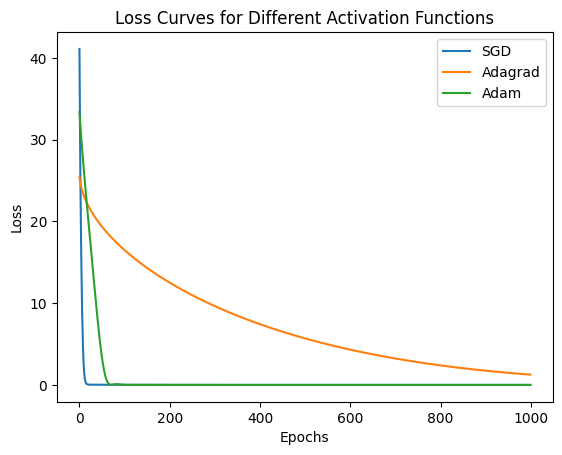

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 生成一些随机数据作为训练集
np.random.seed(2)
x = np.random.rand(100, 1)
y = 3 * x + 4 + np.random.rand(100, 1) * 0.2
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

# 定义一个简单的神经网络模型
class SimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # 使用ReLU作为激活函数
        x = self.fc2(x)
        return x

input_dim = 1
hidden_dim = 10
output_dim = 1

# 实例化神经网络模型和定义损失函数以及优化器
model = SimpleNet(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
learning_rate = 0.01
optimizer_list = [optim.SGD, optim.Adagrad, optim.Adam]
# 开始训练模型
num_epochs = 1000

for optimizer in optimizer_list:
    #重置模型参数
    model = SimpleNet(input_dim, hidden_dim, output_dim)
    # 重置优化器
    optimizer_t = optimizer(model.parameters(), lr=learning_rate)
    losses = []
    for epoch in range(num_epochs):
        # 前向传播
        outputs = model(x)
        loss = criterion(outputs, y)
        # 反向传播
        optimizer_t.zero_grad()
        loss.backward()
        optimizer_t.step()
        losses.append(loss.item())
        optimizer_t.zero_grad()
    # 绘制损失函数随迭代次数的变化曲线
    plt.plot(range(num_epochs), losses, label=optimizer_t.__class__.__name__)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves for Different Activation Functions')
plt.legend()
plt.show()


同理我们也可以实现不同激活函数对实验结果的影响，原理相似，这里不再缀上冗余代码

## 扩展二、用神经网络实现三角函数的拟合
下面是三角函数sin函数，cos函数，tanh函数进行尝试拟合

In [90]:
import torch
import matplotlib.pyplot as plt

# 定义三角函数
def sin_func(x):
    return torch.sin(x)

def cos_func(x):
    return torch.cos(x)

def tanh_func(x):
    return torch.tanh(x)

# 构造训练数据
x_train = torch.linspace(-2 * 3.1416, 2 * 3.1416, 1000)
y_train_sin = sin_func(x_train)
y_train_cos = cos_func(x_train)
y_train_tanh = tanh_func(x_train)

# 定义单层神经网络模型，这里使用单层的全连接网络
class Net_single(nn.Module):
    def __init__(self):
        super(Net_single, self).__init__()
        self.fc = nn.Linear(1, 1)
        
    def forward(self, x):
        out = self.fc(x)
        return out

# 定义神经网络模型，这里使用单层的全连接网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 100)   # 输入层到隐藏层
        self.fc2 = nn.Linear(100, 1)   # 隐藏层到输出层
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))    # 使用sin激活函数
        x = self.fc2(x)
        return x

net_sin = Net_single()
net_cos = Net_single()
net_tanh = Net_single()

# 定义损失函数和优化器
criterion = torch.nn.MSELoss()
optimizer_sin = torch.optim.Adam(net_sin.parameters(), lr=0.01)
optimizer_cos = torch.optim.Adam(net_cos.parameters(), lr=0.01)
optimizer_tanh = torch.optim.Adam(net_tanh.parameters(), lr=0.01)

# 训练模型
for epoch in range(10000):
    # 训练sin函数拟合
    optimizer_sin.zero_grad()
    y_pred_sin = net_sin(x_train.unsqueeze(1))
    loss_sin = criterion(y_pred_sin, y_train_sin.unsqueeze(1))
    loss_sin.backward()
    optimizer_sin.step()

    # 训练cos函数拟合
    optimizer_cos.zero_grad()
    y_pred_cos = net_cos(x_train.unsqueeze(1))
    loss_cos = criterion(y_pred_cos, y_train_cos.unsqueeze(1))
    loss_cos.backward()
    optimizer_cos.step()

    # 训练tanh函数拟合
    optimizer_tanh.zero_grad()
    y_pred_tanh = net_tanh(x_train.unsqueeze(1))
    loss_tanh = criterion(y_pred_tanh, y_train_tanh.unsqueeze(1))
    loss_tanh.backward()
    optimizer_tanh.step()


上面我们结束了模型的训练过程，我们把我们模型训练的拟合效果合真实效果进行对比。其中真实图像label为函数名例如sin，神经网络拟合效果为sin_fit，我们可以看到结果中，拟合效果合真实效果非常接近。基本重合

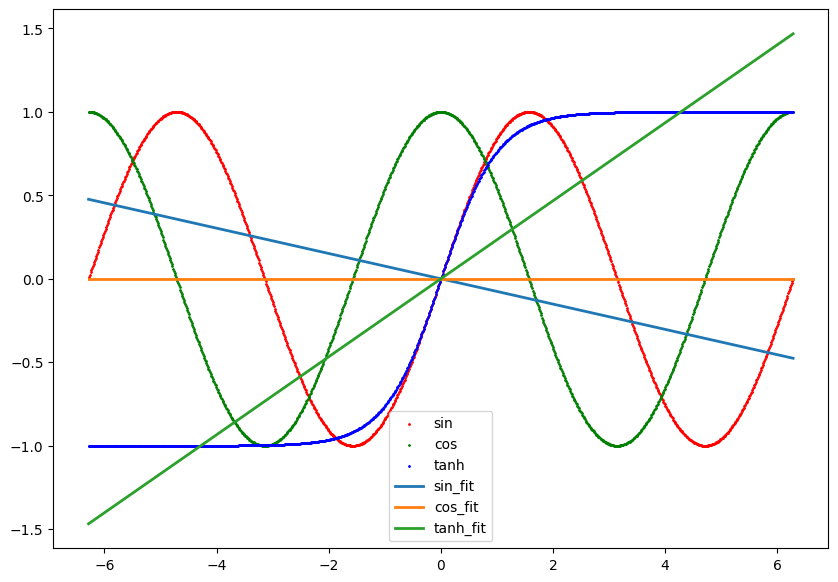

In [91]:
# 可视化结果
plt.figure(figsize=(10, 7))
plt.scatter(x_train.numpy(), y_train_sin.numpy(), s=1, c='r', label='sin')
plt.scatter(x_train.numpy(), y_train_cos.numpy(), s=1, c='g', label='cos')
plt.scatter(x_train.numpy(), y_train_tanh.numpy(), s=1, c='b', label='tanh')
plt.plot(x_train.numpy(), net_sin(x_train.unsqueeze(1)).detach().numpy(), label='sin_fit',linewidth=2)
plt.plot(x_train.numpy(), net_cos(x_train.unsqueeze(1)).detach().numpy(), label='cos_fit',linewidth=2)
plt.plot(x_train.numpy(), net_tanh(x_train.unsqueeze(1)).detach().numpy(), label='tanh_fit',linewidth=2)
plt.legend()
plt.show()

我们可以从上面实验结果发现，单层神经网络无法拟合sin，cos，tanh函数。
 - sin函数是一个非线性函数，单层神经网络无法拟合非线性函数。因为我们根据课程知识可以知道单层神经网络是一个非线性函数，多个非线性函数的叠加还是一个非线性函数，所以单层神经网络无法拟合sin函数。


所以我们下面都用两层神经网络实现三角函数的的拟合，我们观察两层的拟合效果

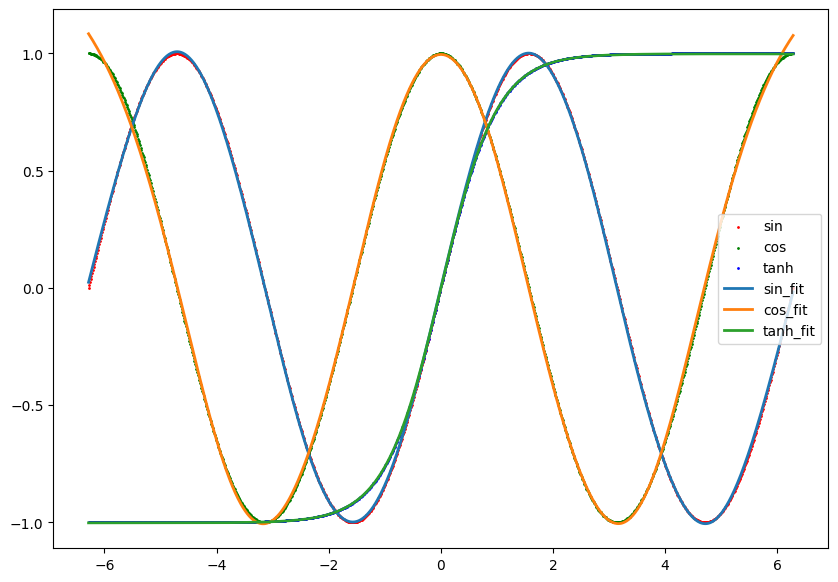

In [92]:
net_sin = Net()
net_cos = Net()
net_tanh = Net()

# 定义损失函数和优化器
criterion = torch.nn.MSELoss()
optimizer_sin = torch.optim.Adam(net_sin.parameters(), lr=0.01)
optimizer_cos = torch.optim.Adam(net_cos.parameters(), lr=0.01)
optimizer_tanh = torch.optim.Adam(net_tanh.parameters(), lr=0.01)

# 训练模型
for epoch in range(10000):
    # 训练sin函数拟合
    optimizer_sin.zero_grad()
    y_pred_sin = net_sin(x_train.unsqueeze(1))
    loss_sin = criterion(y_pred_sin, y_train_sin.unsqueeze(1))
    loss_sin.backward()
    optimizer_sin.step()

    # 训练cos函数拟合
    optimizer_cos.zero_grad()
    y_pred_cos = net_cos(x_train.unsqueeze(1))
    loss_cos = criterion(y_pred_cos, y_train_cos.unsqueeze(1))
    loss_cos.backward()
    optimizer_cos.step()

    # 训练tanh函数拟合
    optimizer_tanh.zero_grad()
    y_pred_tanh = net_tanh(x_train.unsqueeze(1))
    loss_tanh = criterion(y_pred_tanh, y_train_tanh.unsqueeze(1))
    loss_tanh.backward()
    optimizer_tanh.step()
# 可视化结果
plt.figure(figsize=(10, 7))
plt.scatter(x_train.numpy(), y_train_sin.numpy(), s=1, c='r', label='sin')
plt.scatter(x_train.numpy(), y_train_cos.numpy(), s=1, c='g', label='cos')
plt.scatter(x_train.numpy(), y_train_tanh.numpy(), s=1, c='b', label='tanh')
plt.plot(x_train.numpy(), net_sin(x_train.unsqueeze(1)).detach().numpy(), label='sin_fit',linewidth=2)
plt.plot(x_train.numpy(), net_cos(x_train.unsqueeze(1)).detach().numpy(), label='cos_fit',linewidth=2)
plt.plot(x_train.numpy(), net_tanh(x_train.unsqueeze(1)).detach().numpy(), label='tanh_fit',linewidth=2)
plt.legend()
plt.show()

我们可以看到使用两层神经网络可以得到更好的拟合效果，所以后面的实验任务都使用两层神经网络来实现。

### 下面我们尝试使用两层神经网络来拟合sin，cos，tanh函数，为了便于观察神经网络的拟合效果随着epoch的变化
我们把每100个epoch的拟合效果可视化出来，我们可以看到随着epoch的增加，神经网络的拟合效果越来越好。

Epoch [100/2000], Loss: 0.1252


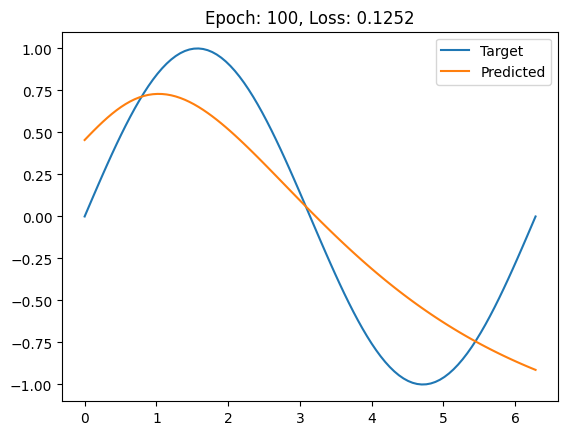

Epoch [200/2000], Loss: 0.0711


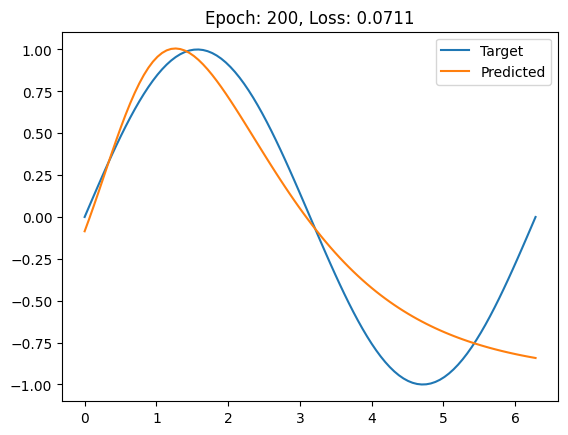

Epoch [300/2000], Loss: 0.0539


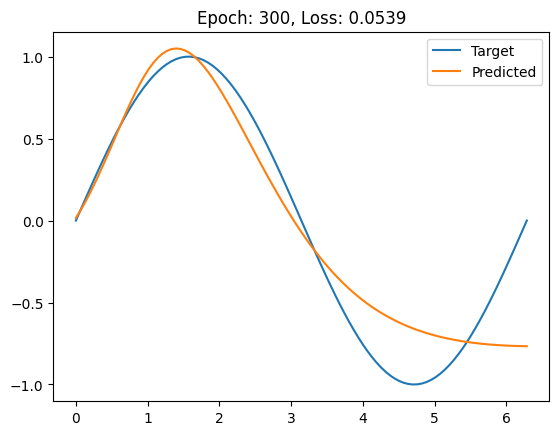

Epoch [400/2000], Loss: 0.0402


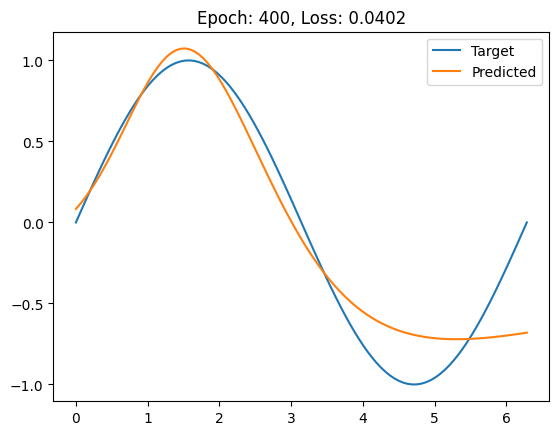

Epoch [500/2000], Loss: 0.0268


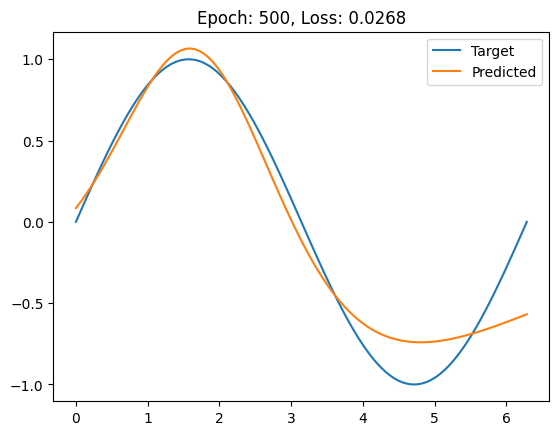

Epoch [600/2000], Loss: 0.0141


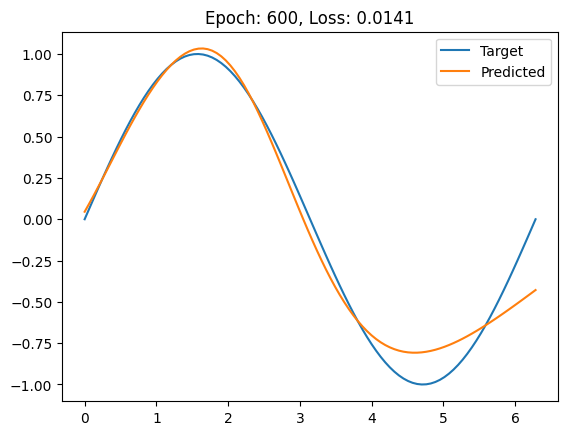

Epoch [700/2000], Loss: 0.0060


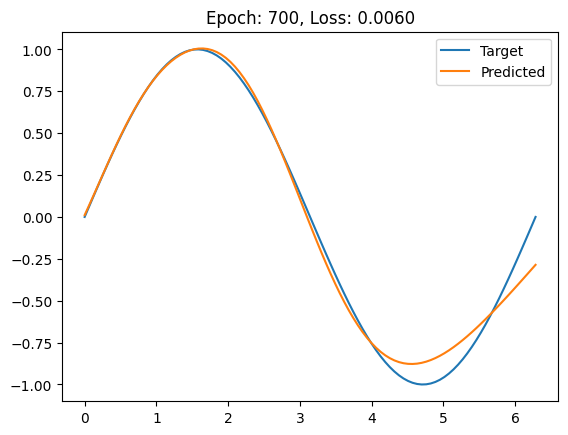

Epoch [800/2000], Loss: 0.0030


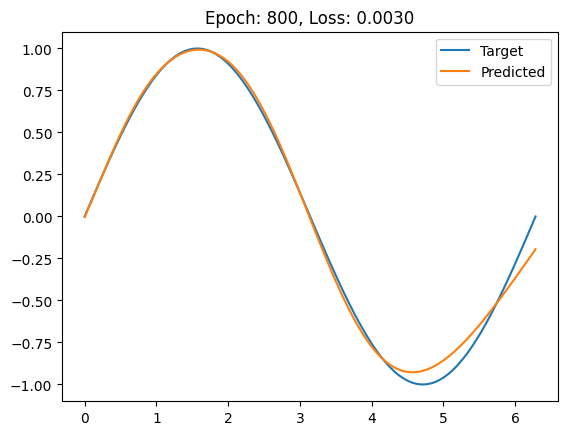

Epoch [900/2000], Loss: 0.0015


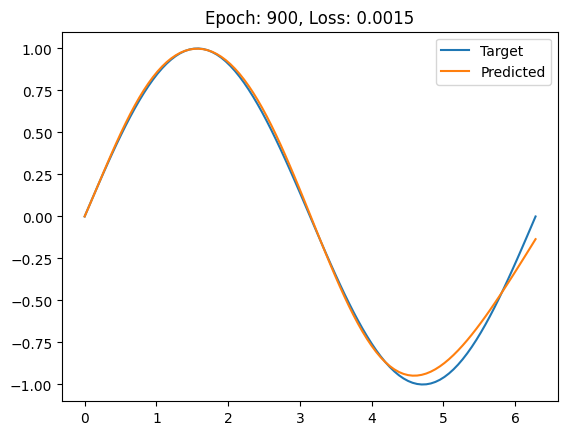

Epoch [1000/2000], Loss: 0.0008


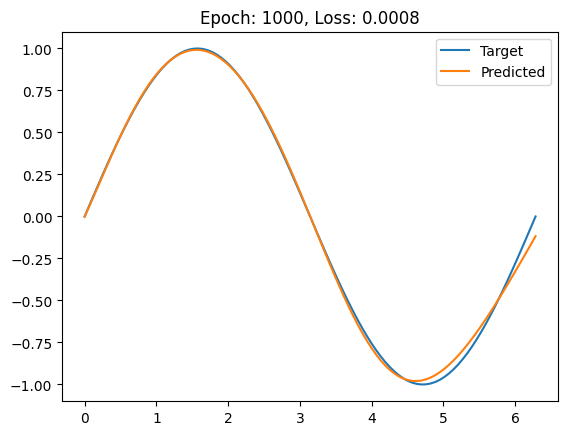

Epoch [1100/2000], Loss: 0.0005


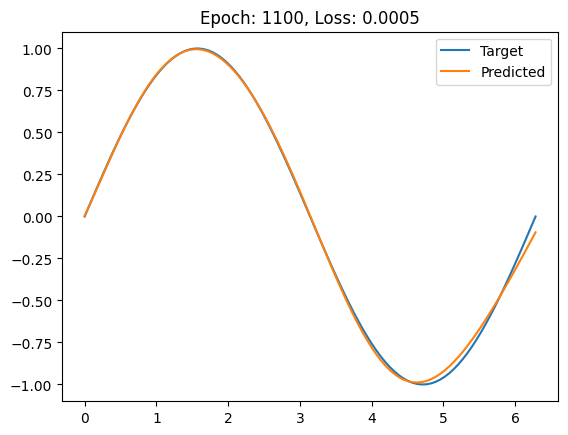

Epoch [1200/2000], Loss: 0.0004


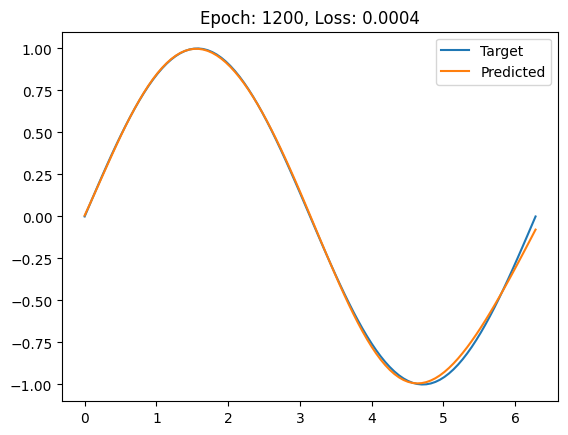

Epoch [1300/2000], Loss: 0.0010


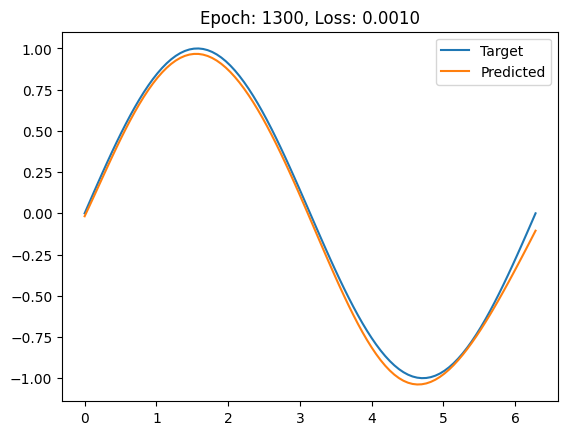

Epoch [1400/2000], Loss: 0.0002


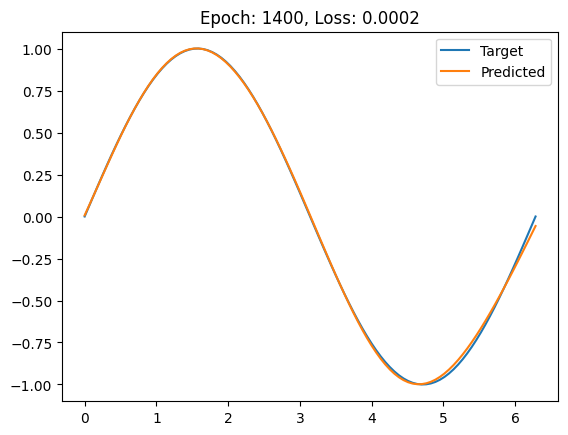

Epoch [1500/2000], Loss: 0.0002


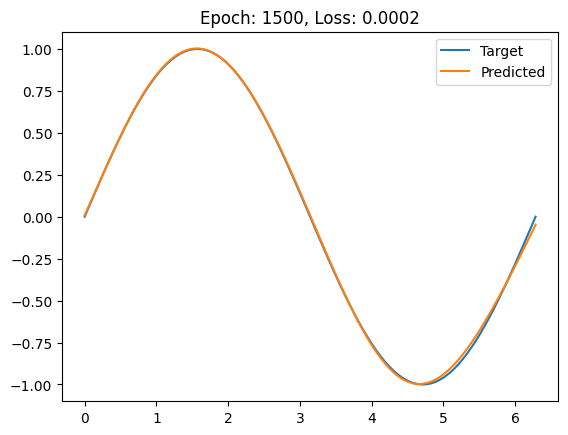

Epoch [1600/2000], Loss: 0.0001


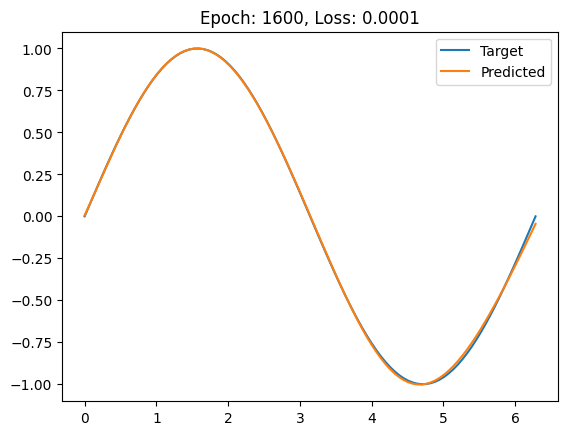

Epoch [1700/2000], Loss: 0.0001


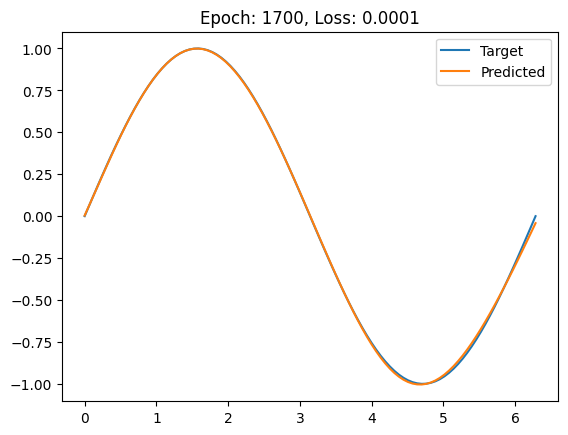

Epoch [1800/2000], Loss: 0.0001


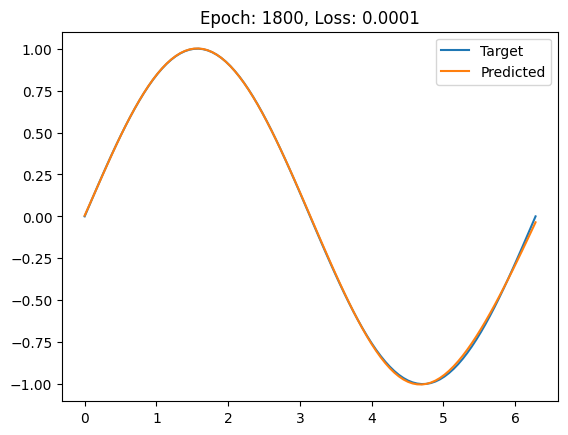

Epoch [1900/2000], Loss: 0.0001


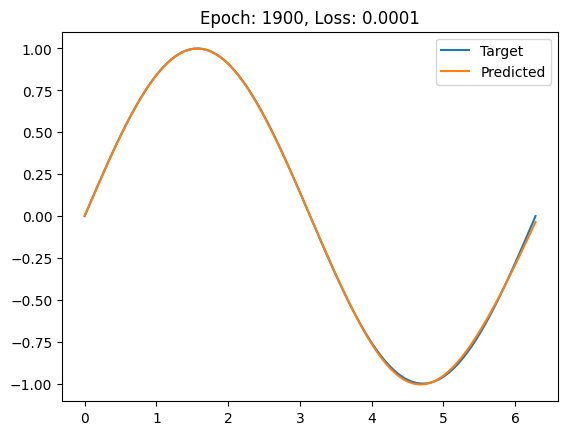

Epoch [2000/2000], Loss: 0.0001


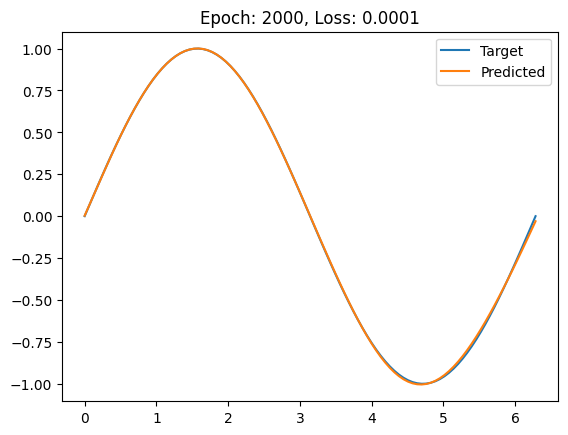

In [93]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 生成训练数据
x = np.linspace(0, 2*np.pi, 100)  # 生成0-2π之间的100个点
y_sin = np.sin(x)                    # 目标输出
y_cos = np.cos(x)
y_tan = np.tan(x)
y_tanh = np.tanh(x) # tanh函数

# 转换为PyTorch张量
x_tensor = torch.from_numpy(x).float().view(-1, 1)
y_tensor = torch.from_numpy(y_sin).float().view(-1, 1)

# 定义神经网络模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 100)   # 输入层到隐藏层
        self.fc2 = nn.Linear(100, 1)   # 隐藏层到输出层
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))    # 使用sin激活函数
        x = self.fc2(x)
        return x
# 创建模型实例
model = Net()
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# 训练模型
num_epochs = 2000
for epoch in range(num_epochs):
    # 前向传播
    outputs = model(x_tensor)
    loss = criterion(outputs, y_tensor)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            predicted = model(x_tensor)

        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))      
        # 可视化结果
        plt.title('Epoch: {}, Loss: {:.4f}'.format(epoch+1, loss.item()))
        plt.plot(x, y_sin, label='Target')
        plt.plot(x, predicted.numpy(), label='Predicted')
        plt.legend()
        plt.show()

### 下面尝试拟合log函数，而不是三角函数

Epoch [100/1000], Loss: 0.0283


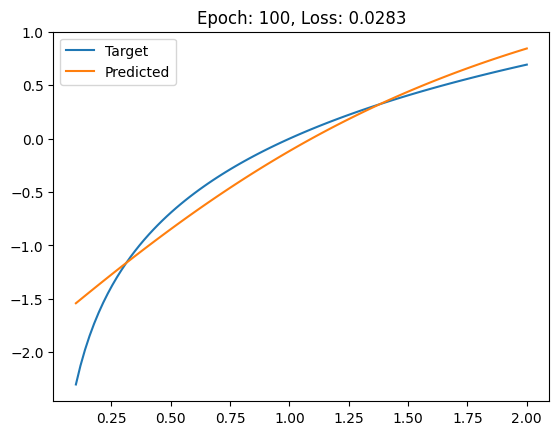

Epoch [200/1000], Loss: 0.0101


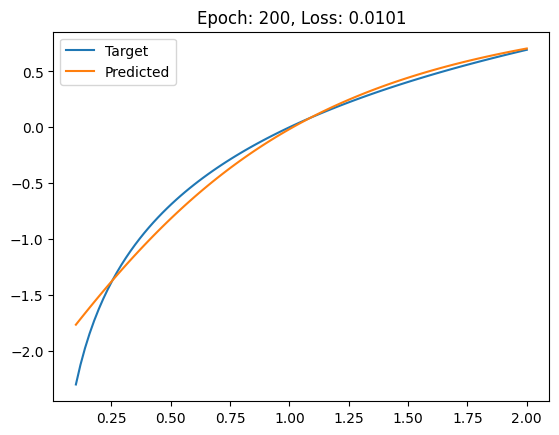

Epoch [300/1000], Loss: 0.0053


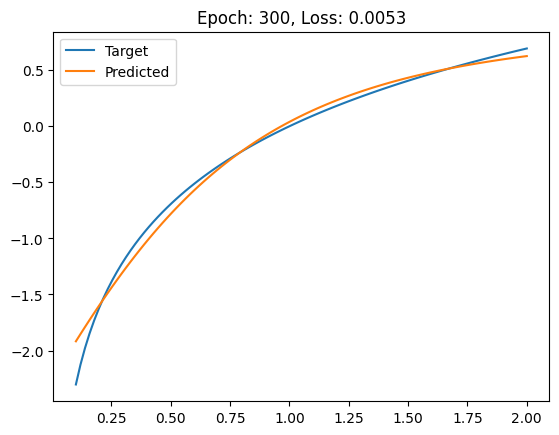

Epoch [400/1000], Loss: 0.0042


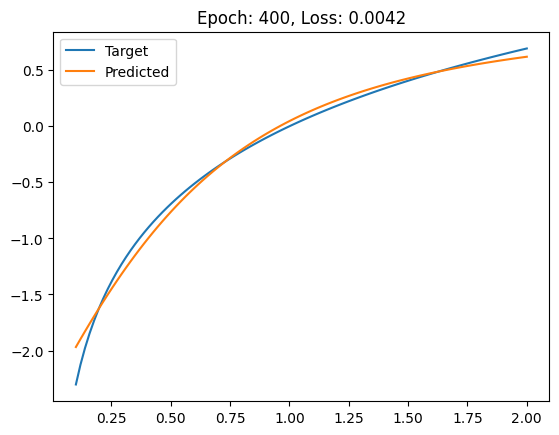

Epoch [500/1000], Loss: 0.0034


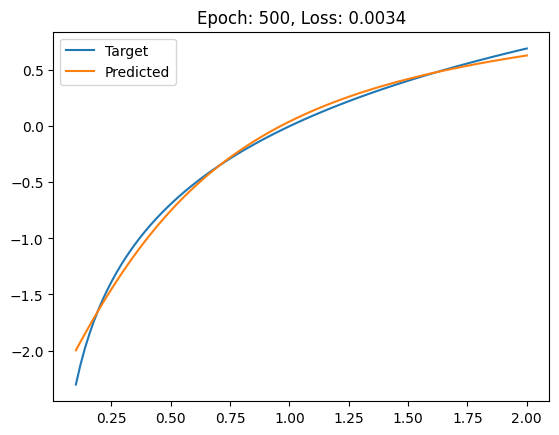

Epoch [600/1000], Loss: 0.0026


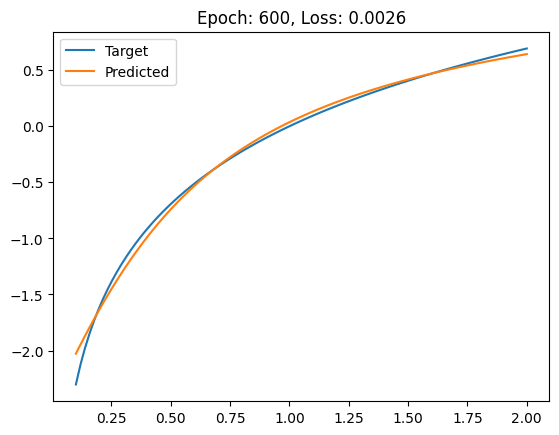

Epoch [700/1000], Loss: 0.0019


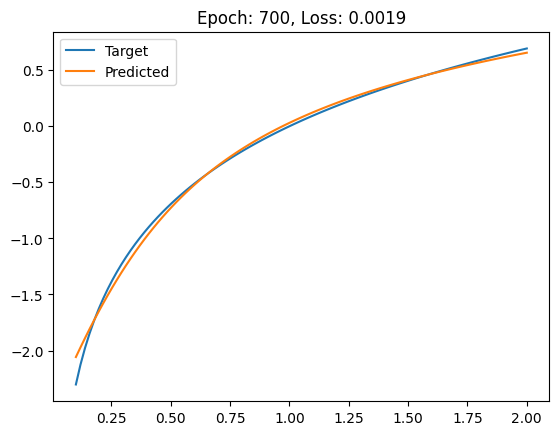

Epoch [800/1000], Loss: 0.0013


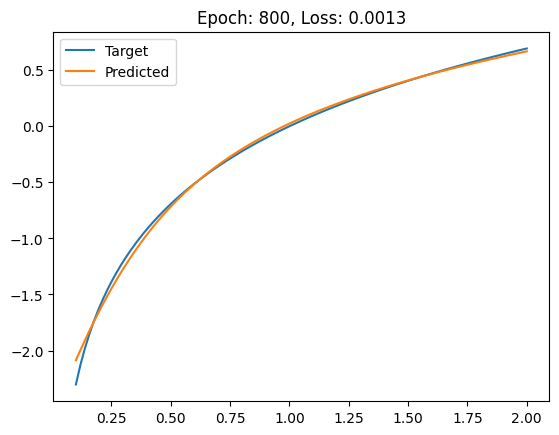

Epoch [900/1000], Loss: 0.0009


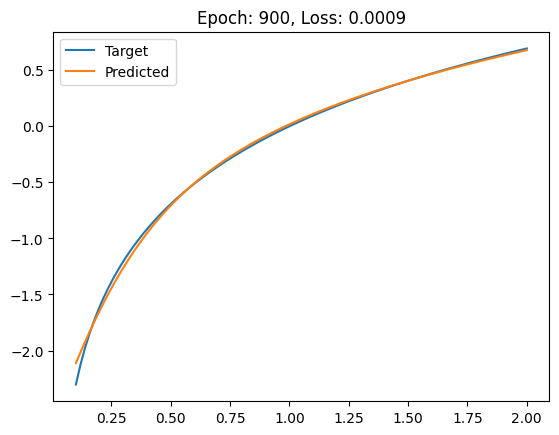

Epoch [1000/1000], Loss: 0.0007


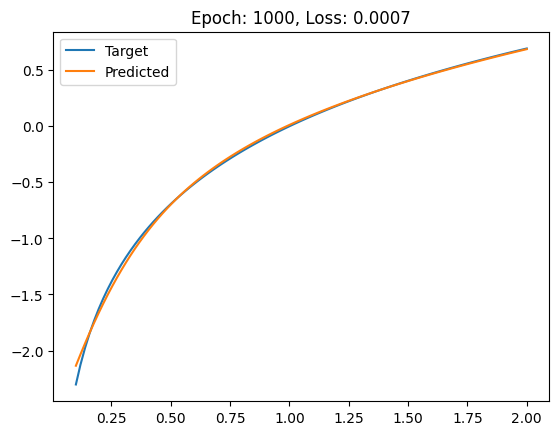

In [94]:
# 拟合log函数
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
# 生成训练数据
x = np.linspace(0.1, 2, 100)  # 生成0.1-2之间的100个点
y_log = np.log(x)             # 目标输出
y_exp = np.exp(x)             # 目标输出
# 转换为PyTorch张量
x_tensor = torch.from_numpy(x).float().view(-1, 1)
y_log_tensor = torch.from_numpy(y_log).float().view(-1, 1)
# 定义神经网络模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 100)   # 输入层到隐藏层
        self.fc2 = nn.Linear(100, 1)   # 隐藏层到输出层
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))    # 使用激活函数
        x = self.fc2(x)
        return x

# 创建模型实例
model = Net()

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 训练模型
num_epochs = 1000
for epoch in range(num_epochs):
    # 前向传播
    outputs = model(x_tensor)
    loss = criterion(outputs, y_log_tensor)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            predicted = model(x_tensor)

        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))      
        # 可视化结果
        plt.title('Epoch: {}, Loss: {:.4f}'.format(epoch+1, loss.item()))
        plt.plot(x, y_log, label='Target')
        plt.plot(x, predicted.numpy(), label='Predicted')
        plt.legend()
        plt.show()


## 扩展三、下面尝试设计一个通用的神经网络拟合函数，可以拟合任意的函数
之前的代码是专门去拟合某一个函数，每次一个新的函数要重新定义一遍神经网路和各种参数，我想把这个网络封装成一个函数，我们只需要传入需要拟合的函数，就可以拟合任意的函数。避免冗长的代码工作量
下面是把我们的代码封装成一个函数，可以拟合任意的函数。不再局限于三角函数。也是每隔一定轮数，可视化一次拟合效果。

In [95]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
pi = 3.1416

def fit_function(target_func,num_epochs = 2000):
    # 生成训练数据
    x = np.linspace(-2*pi, 2*pi, 100)  # 生成0.1-2之间的100个点
    y = target_func(x)            # 目标输出
    # 转换为PyTorch张量
    x_tensor = torch.from_numpy(x).float().view(-1, 1)
    y_tensor = torch.from_numpy(y).float().view(-1, 1)
    # 定义神经网络模型
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(1, 100)   # 输入层到隐藏层
            self.fc2 = nn.Linear(100, 1)   # 隐藏层到输出层
        def forward(self, x):
            x = torch.sigmoid(self.fc1(x))    # 使用激活函数
            x = self.fc2(x)
            return x
    # 创建模型实例
    model = Net()
    # 定义损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # 训练模型
    for epoch in range(num_epochs):
        # 前向传播
        outputs = model(x_tensor)
        loss = criterion(outputs, y_tensor)
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            model.eval()
            with torch.no_grad():
                predicted = model(x_tensor)
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))      
            # 可视化结果
            plt.title('Epoch: {}, Loss: {:.4f}'.format(epoch+1, loss.item()))
            plt.plot(x, y, label='Target')
            plt.plot(x, predicted.numpy(), label='Predicted')
            plt.legend()
            plt.show()

上面的函数注释：
- target_func:需要拟合的函数，例如sin函数，cos函数，log函数，exp函数
- num_epochs:训练的轮数
我们只需要按照指定的函数格式传入函数，下面进行调用可视化。

Epoch [100/2000], Loss: 0.0986


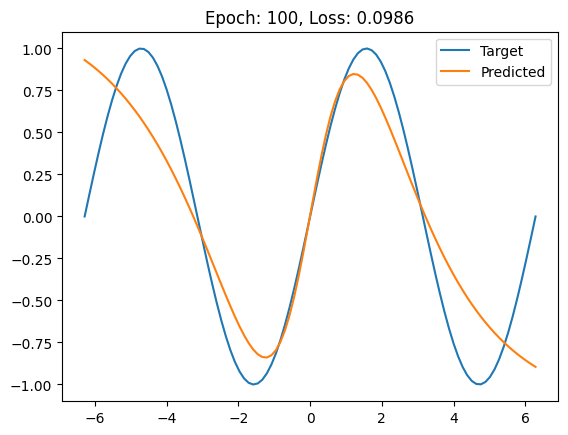

Epoch [200/2000], Loss: 0.0787


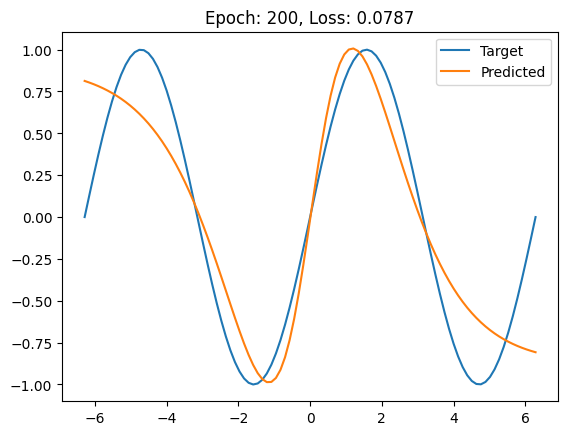

Epoch [300/2000], Loss: 0.0673


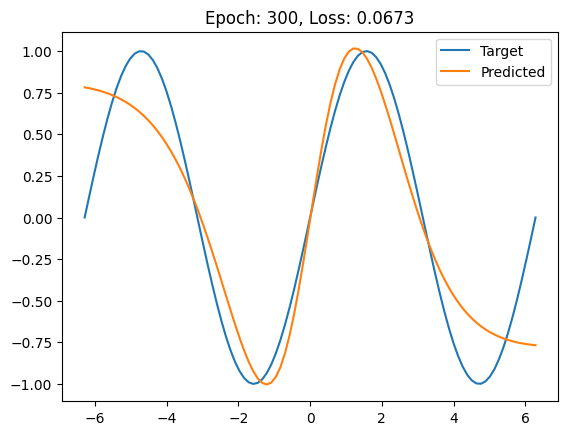

Epoch [400/2000], Loss: 0.0511


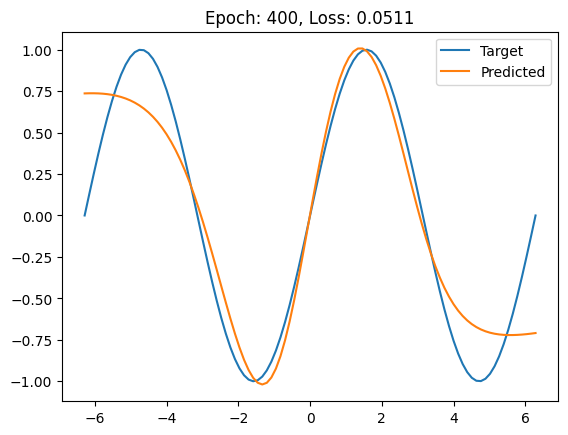

Epoch [500/2000], Loss: 0.0358


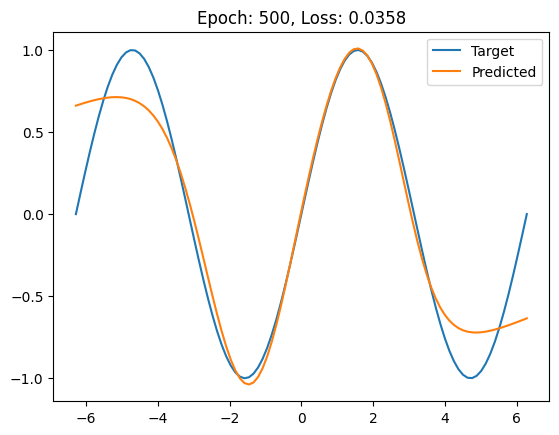

Epoch [600/2000], Loss: 0.0253


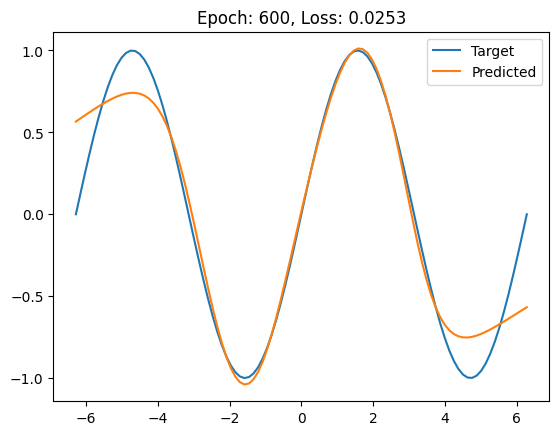

Epoch [700/2000], Loss: 0.0168


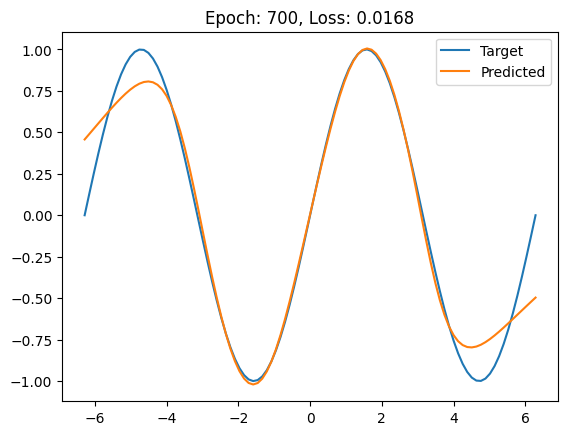

Epoch [800/2000], Loss: 0.0093


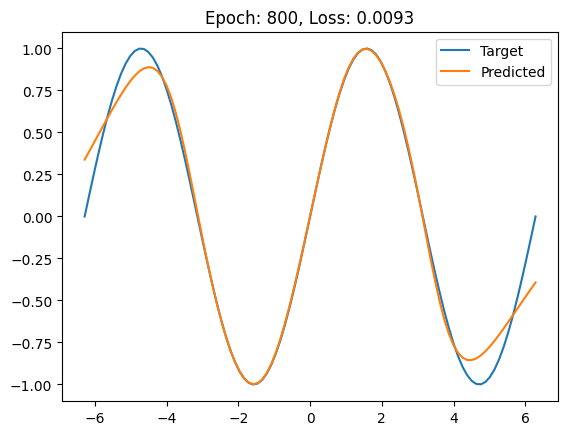

Epoch [900/2000], Loss: 0.0060


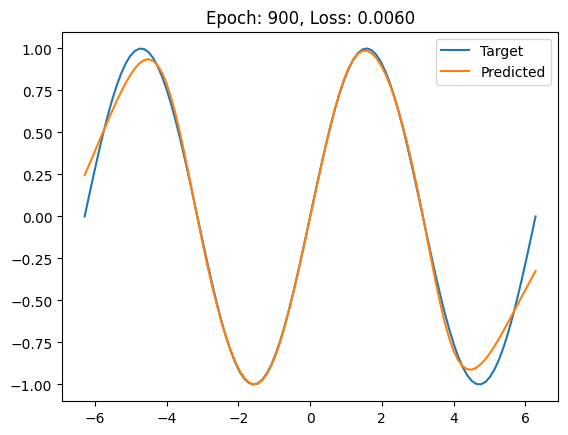

Epoch [1000/2000], Loss: 0.0035


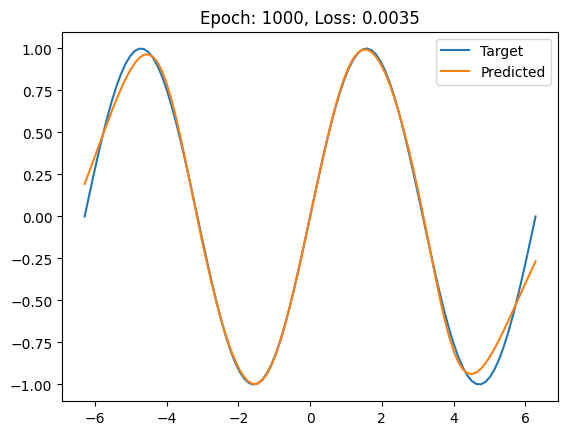

Epoch [1100/2000], Loss: 0.0024


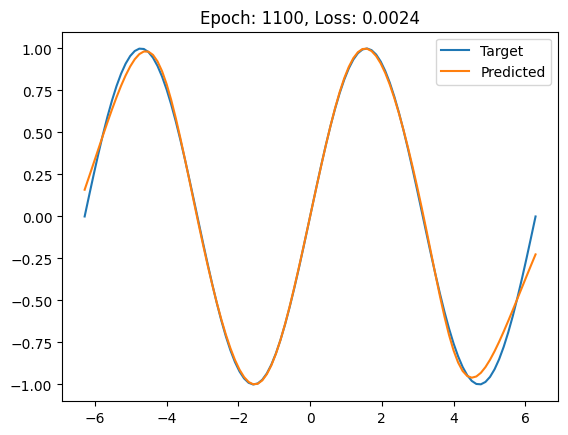

Epoch [1200/2000], Loss: 0.0018


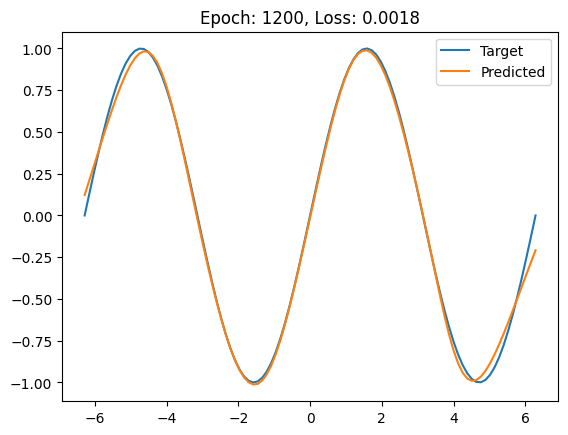

Epoch [1300/2000], Loss: 0.0013


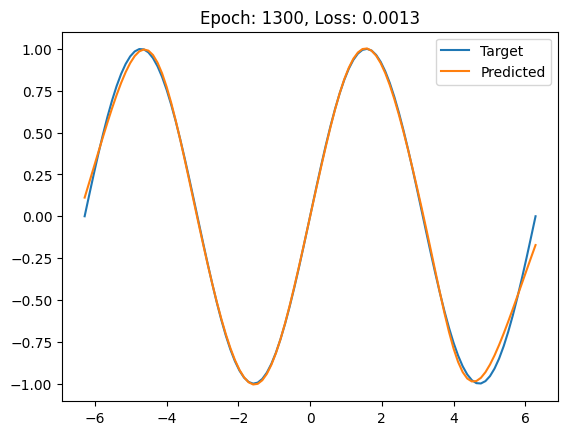

Epoch [1400/2000], Loss: 0.0010


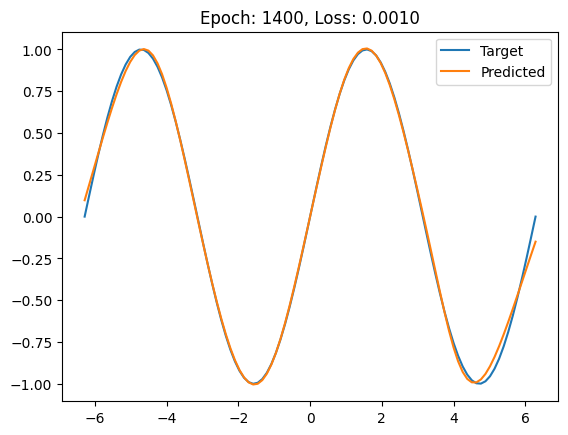

Epoch [1500/2000], Loss: 0.0008


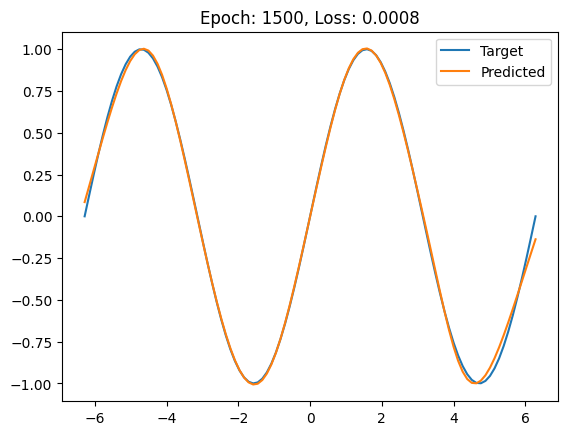

Epoch [1600/2000], Loss: 0.0006


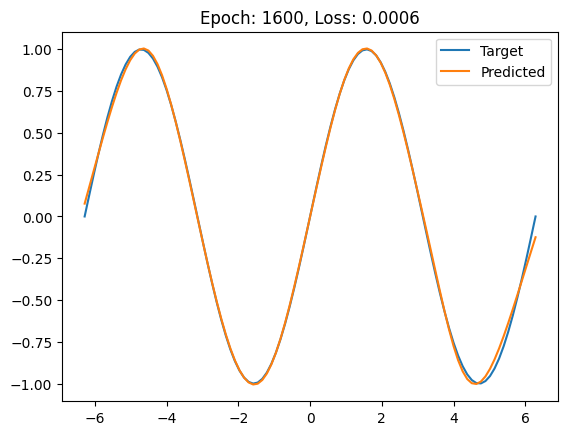

Epoch [1700/2000], Loss: 0.0006


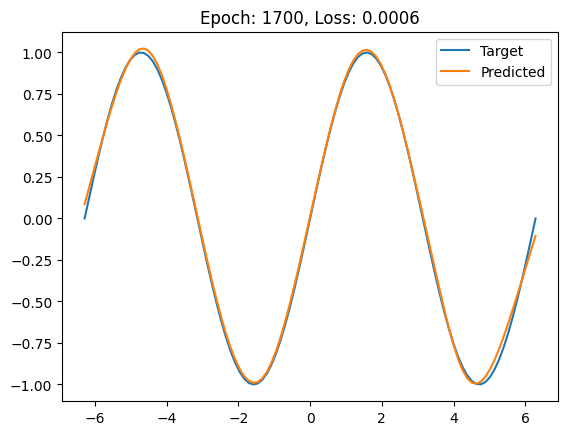

Epoch [1800/2000], Loss: 0.0004


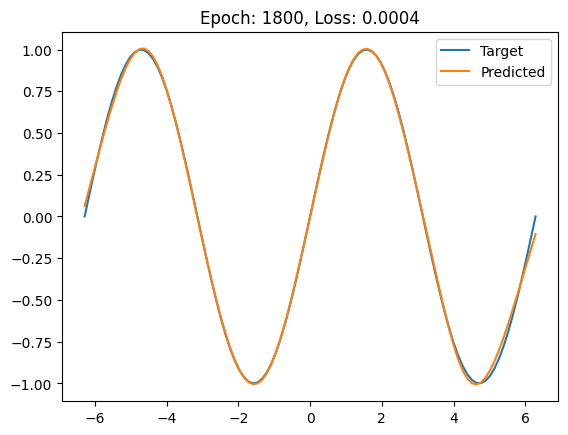

Epoch [1900/2000], Loss: 0.0004


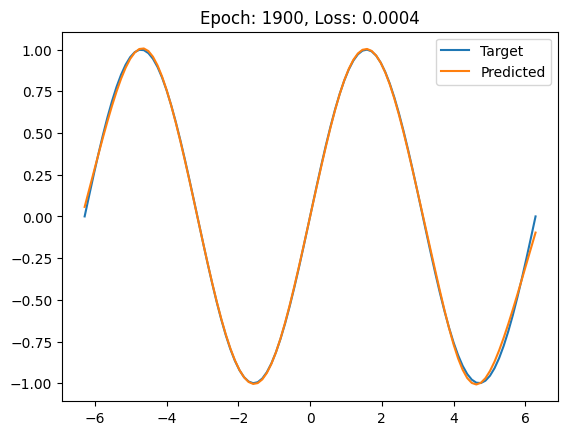

Epoch [2000/2000], Loss: 0.0004


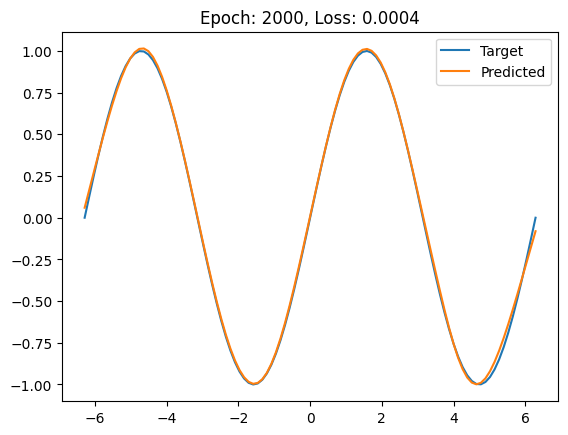

In [96]:
### 查看sin函数拟合效果
fit_function(np.sin,num_epochs=2000)

cos函数

Epoch [100/2000], Loss: 0.0682


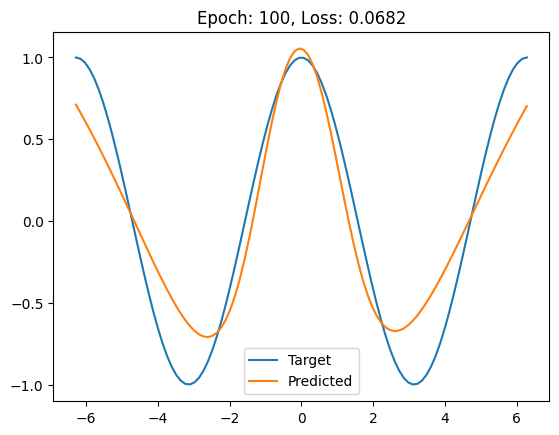

Epoch [200/2000], Loss: 0.0048


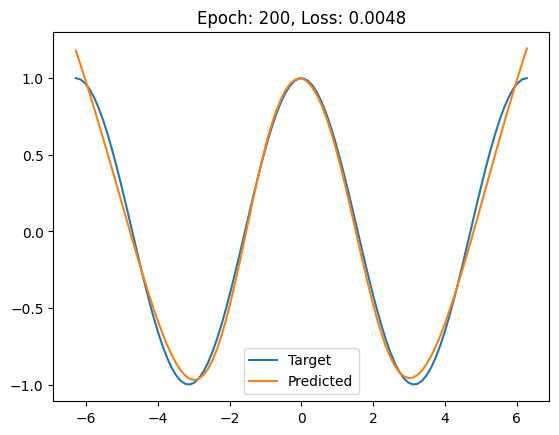

Epoch [300/2000], Loss: 0.0032


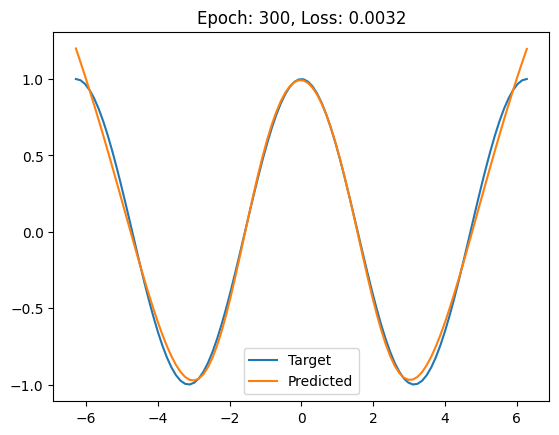

Epoch [400/2000], Loss: 0.0026


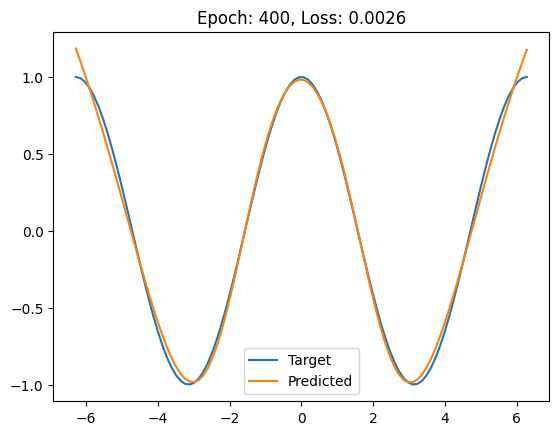

Epoch [500/2000], Loss: 0.0023


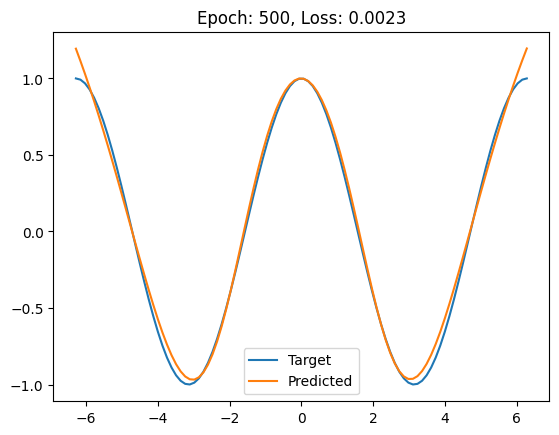

Epoch [600/2000], Loss: 0.0021


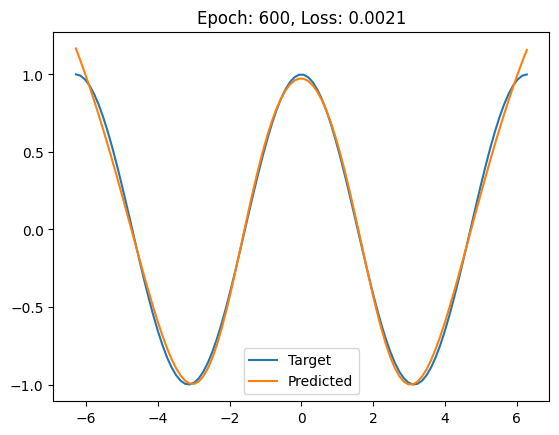

Epoch [700/2000], Loss: 0.0022


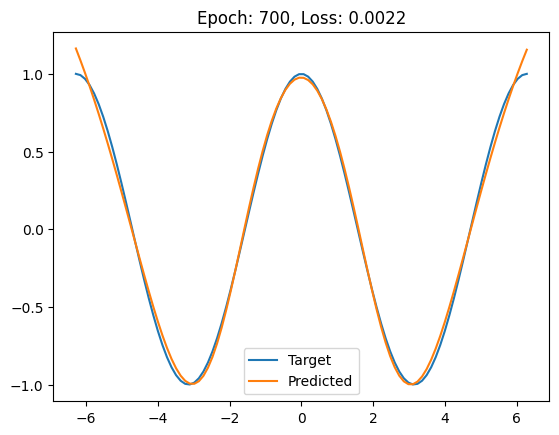

Epoch [800/2000], Loss: 0.0019


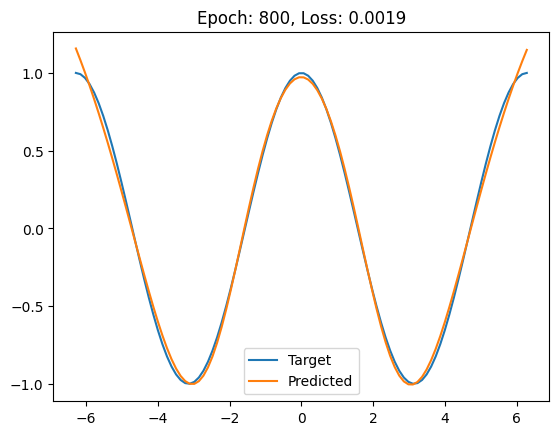

Epoch [900/2000], Loss: 0.0019


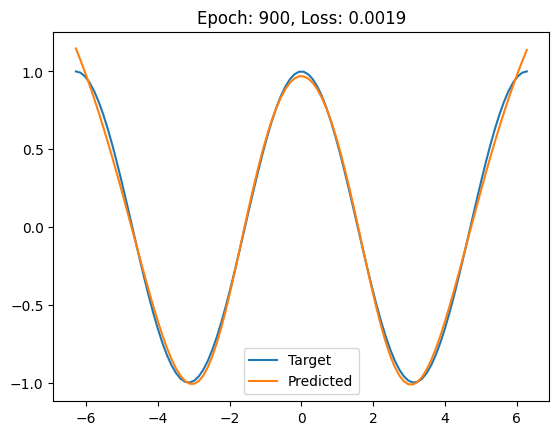

Epoch [1000/2000], Loss: 0.0017


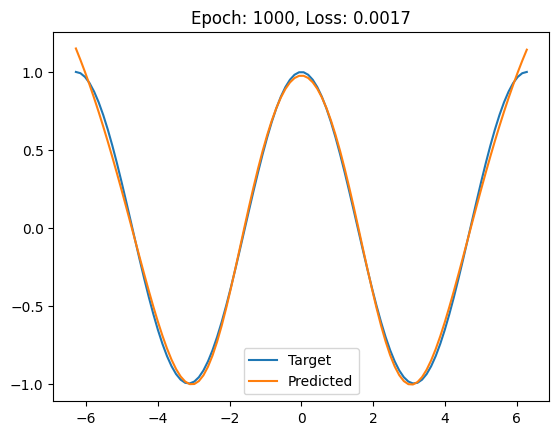

Epoch [1100/2000], Loss: 0.0018


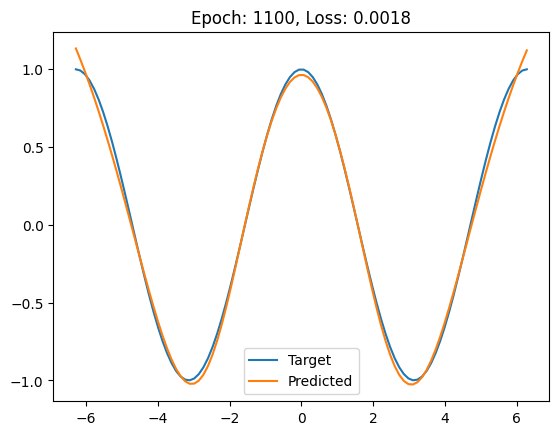

Epoch [1200/2000], Loss: 0.0015


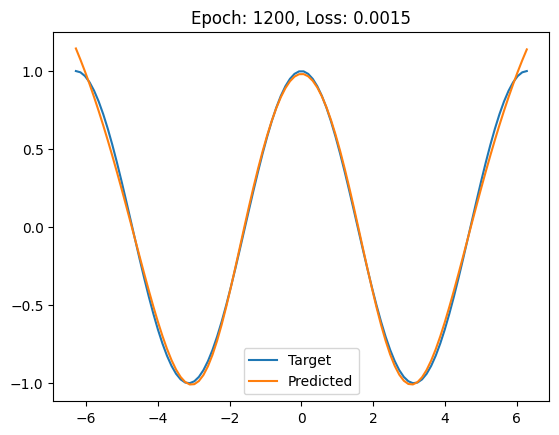

Epoch [1300/2000], Loss: 0.0014


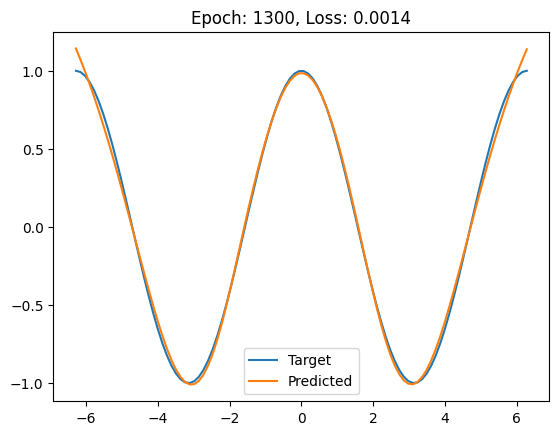

Epoch [1400/2000], Loss: 0.0014


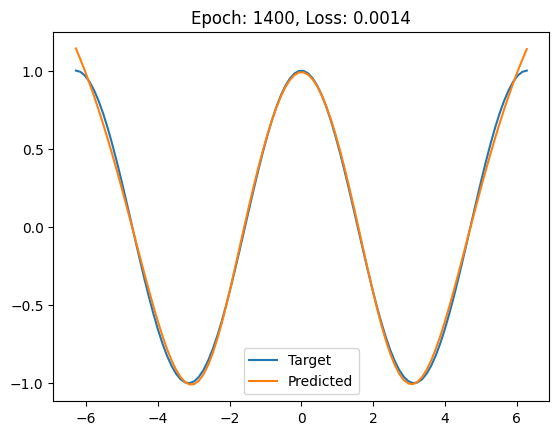

Epoch [1500/2000], Loss: 0.0013


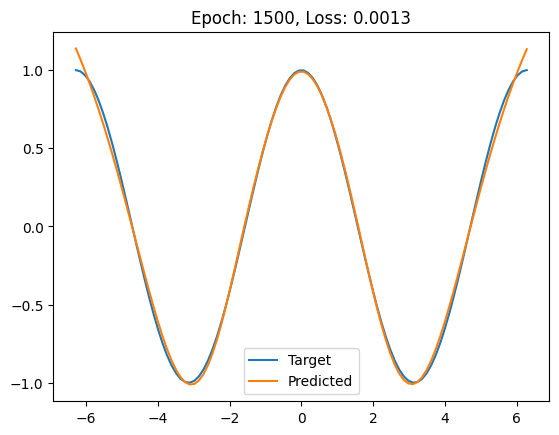

Epoch [1600/2000], Loss: 0.0013


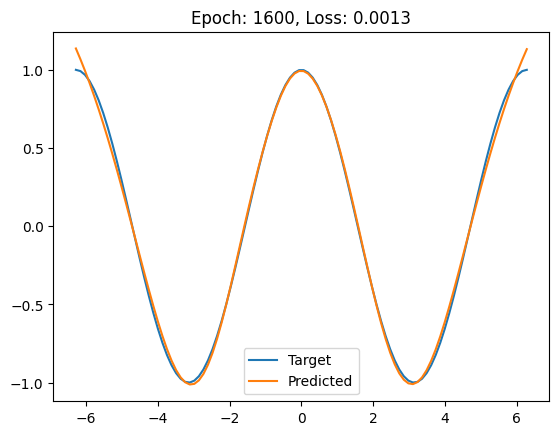

Epoch [1700/2000], Loss: 0.0013


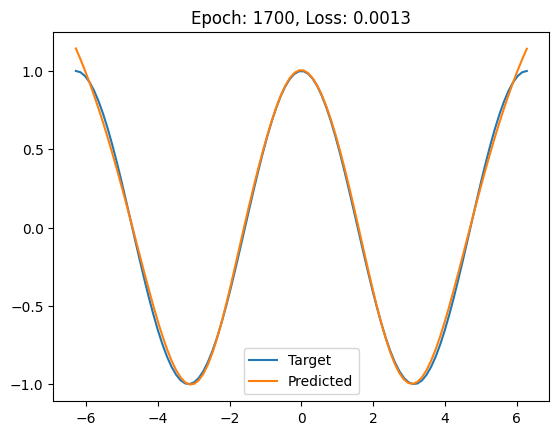

Epoch [1800/2000], Loss: 0.0012


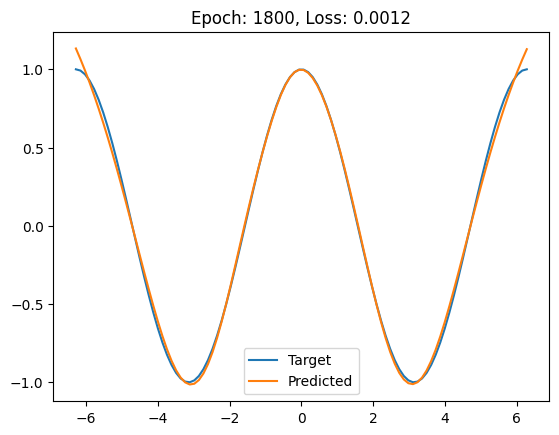

Epoch [1900/2000], Loss: 0.0011


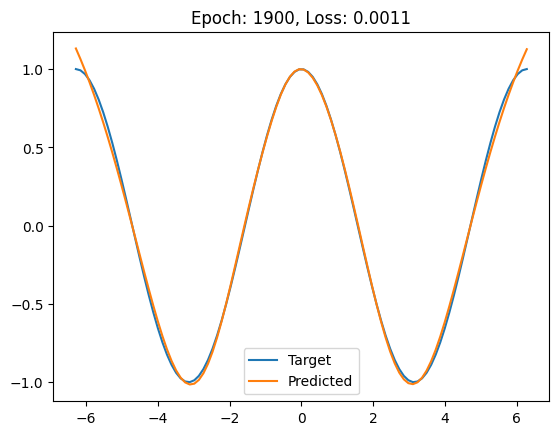

Epoch [2000/2000], Loss: 0.0012


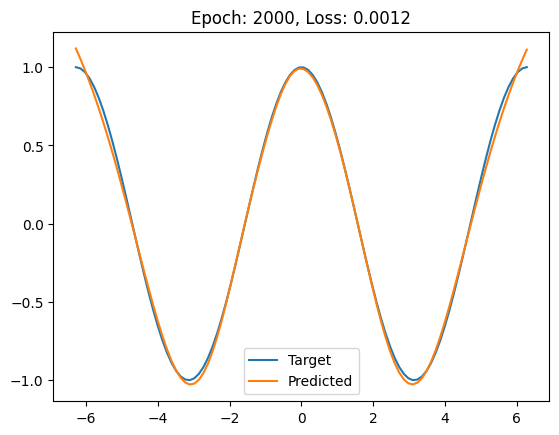

In [97]:
fit_function(np.cos,num_epochs=2000)

exp函数

Epoch [100/2000], Loss: 8003.5693


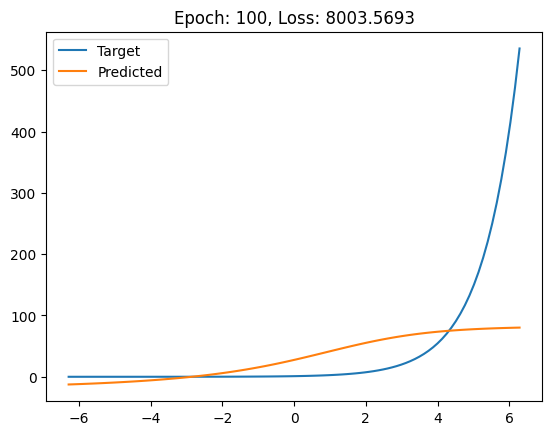

Epoch [200/2000], Loss: 5894.7969


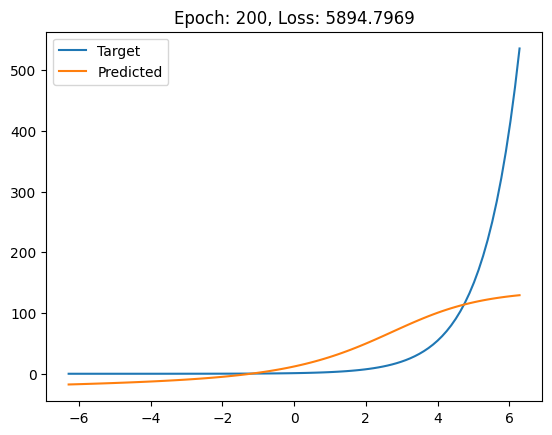

Epoch [300/2000], Loss: 4325.5317


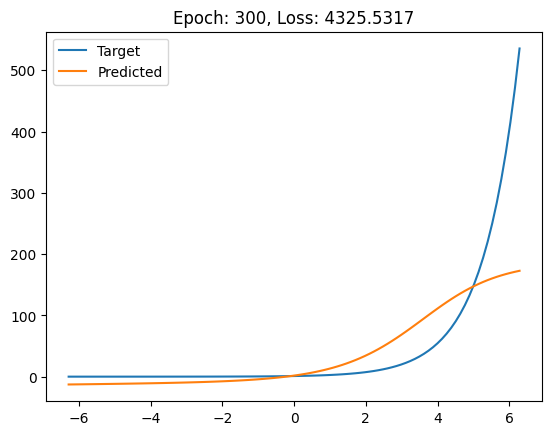

Epoch [400/2000], Loss: 3173.0283


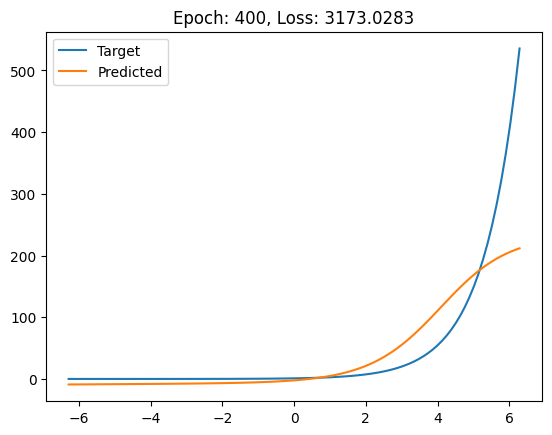

Epoch [500/2000], Loss: 2348.3389


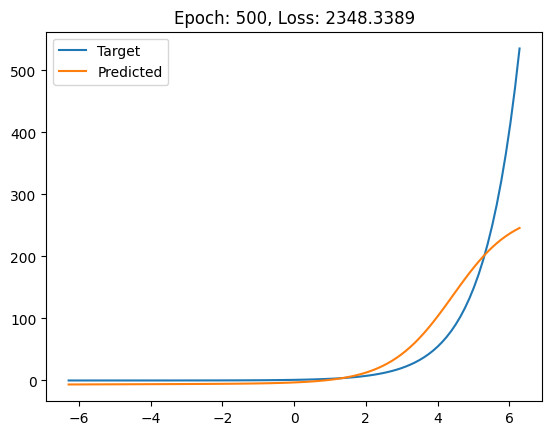

Epoch [600/2000], Loss: 1759.1938


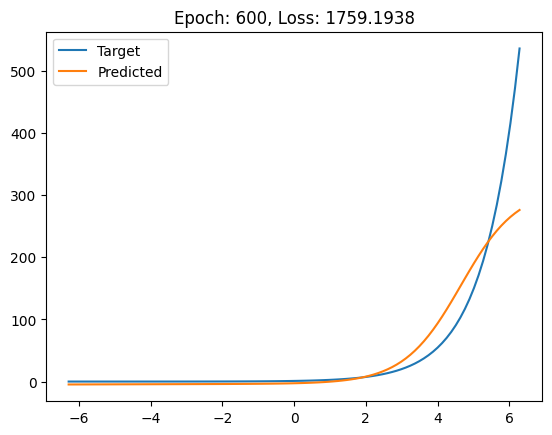

Epoch [700/2000], Loss: 1334.7397


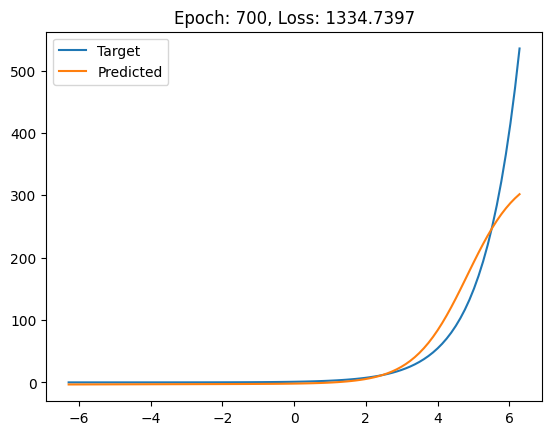

Epoch [800/2000], Loss: 1026.3029


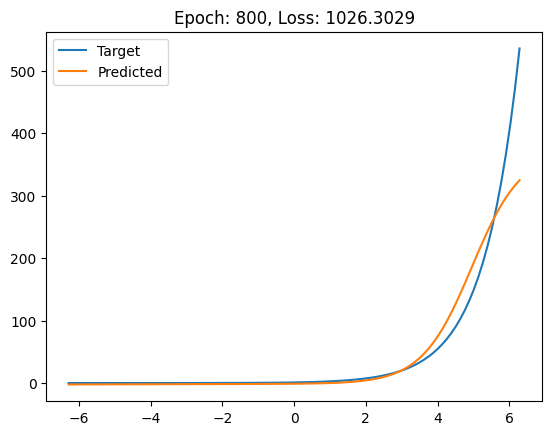

Epoch [900/2000], Loss: 800.5109


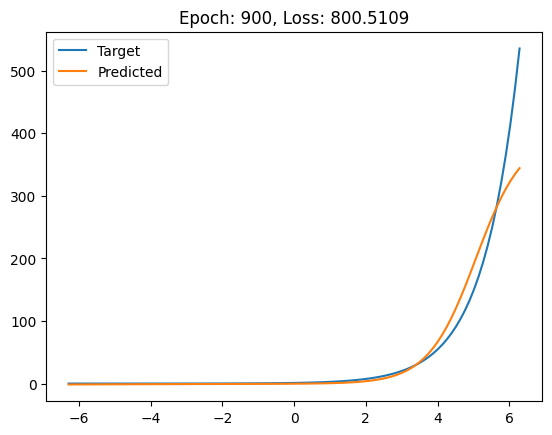

Epoch [1000/2000], Loss: 634.1478


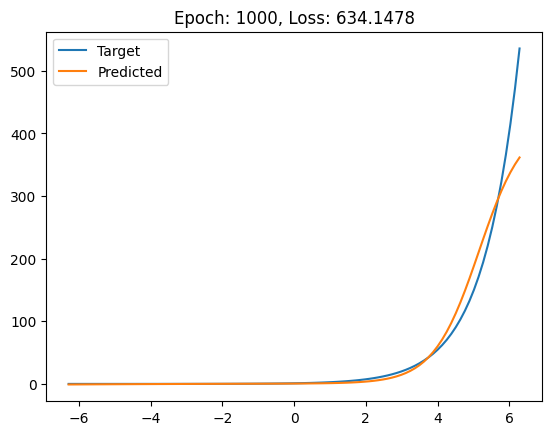

Epoch [1100/2000], Loss: 510.8036


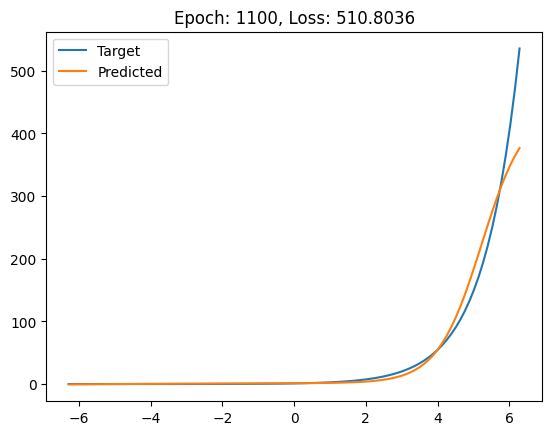

Epoch [1200/2000], Loss: 418.7318


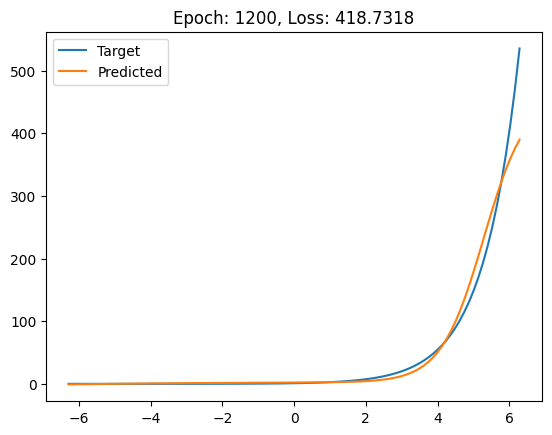

Epoch [1300/2000], Loss: 349.5729


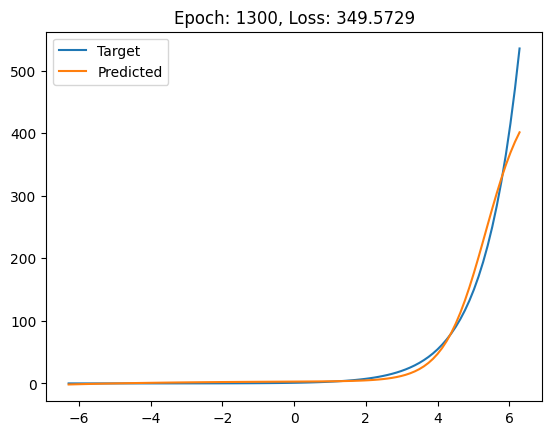

Epoch [1400/2000], Loss: 297.3798


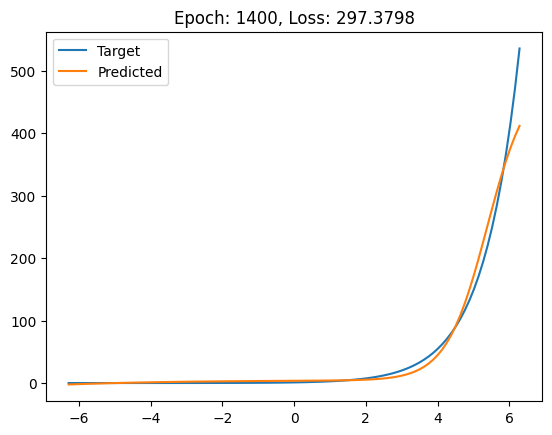

Epoch [1500/2000], Loss: 257.7248


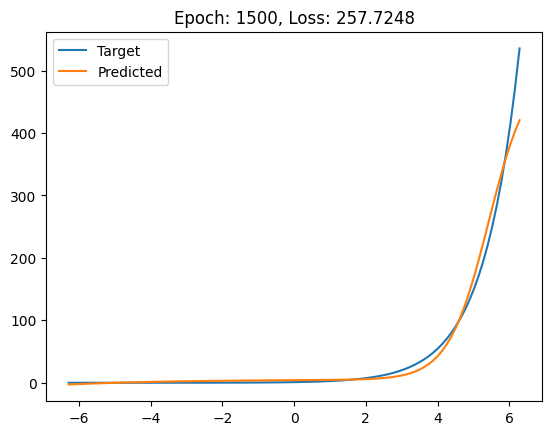

Epoch [1600/2000], Loss: 227.2637


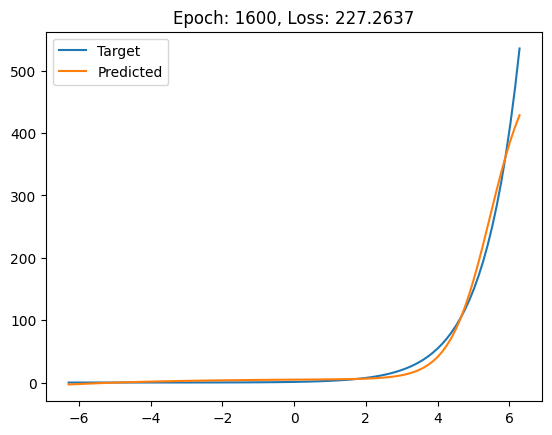

Epoch [1700/2000], Loss: 203.4704


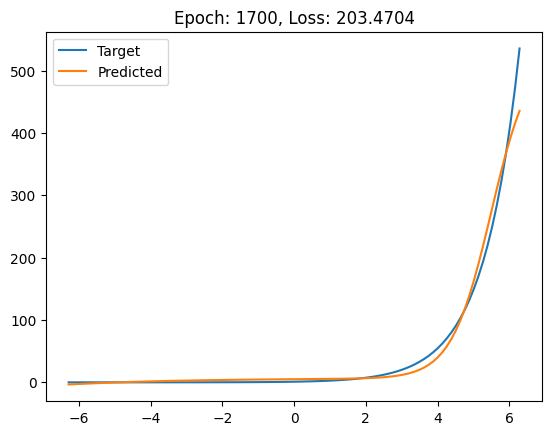

Epoch [1800/2000], Loss: 184.4114


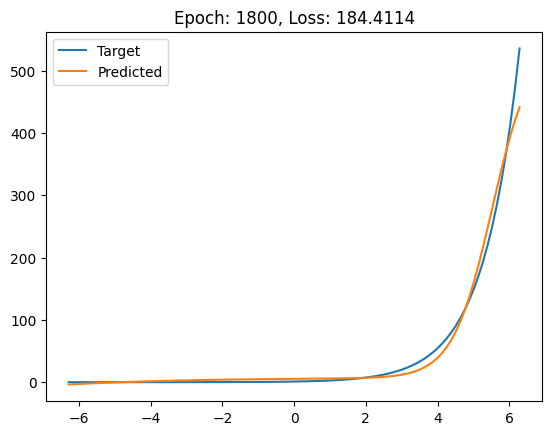

Epoch [1900/2000], Loss: 168.5773


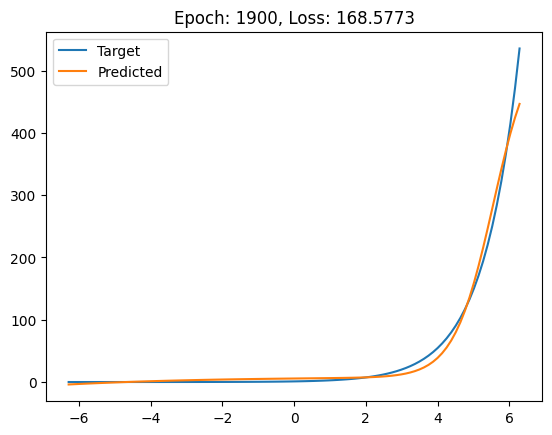

Epoch [2000/2000], Loss: 154.3648


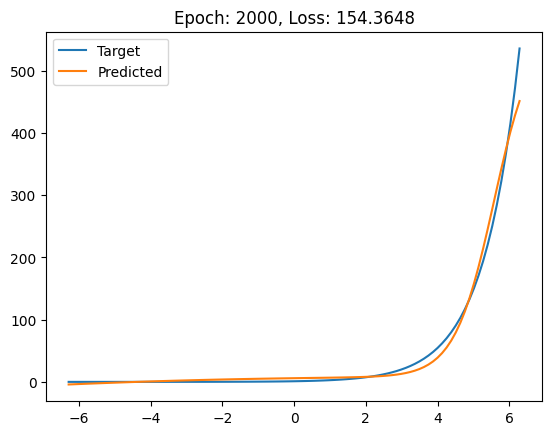

In [98]:
fit_function(np.exp,num_epochs=2000)

tanh函数

Epoch [100/1000], Loss: 0.0034


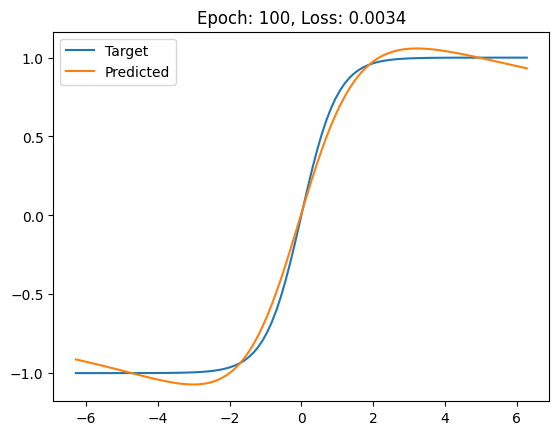

Epoch [200/1000], Loss: 0.0013


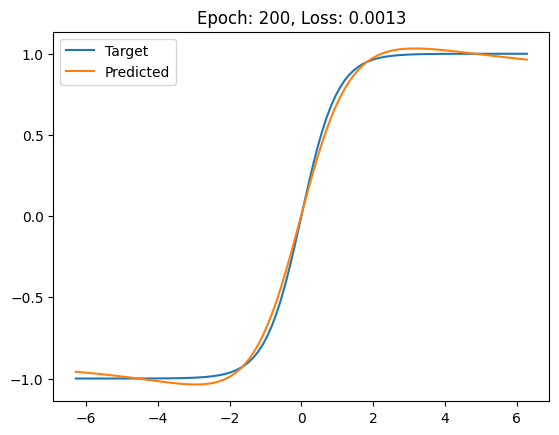

Epoch [300/1000], Loss: 0.0003


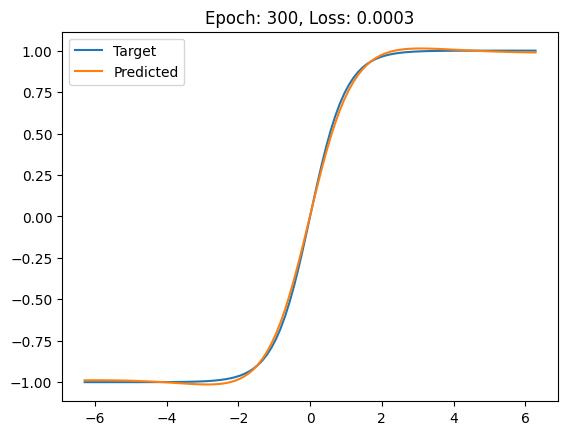

Epoch [400/1000], Loss: 0.0001


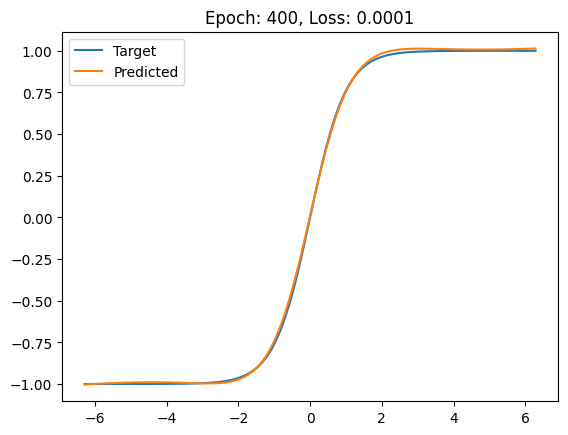

Epoch [500/1000], Loss: 0.0000


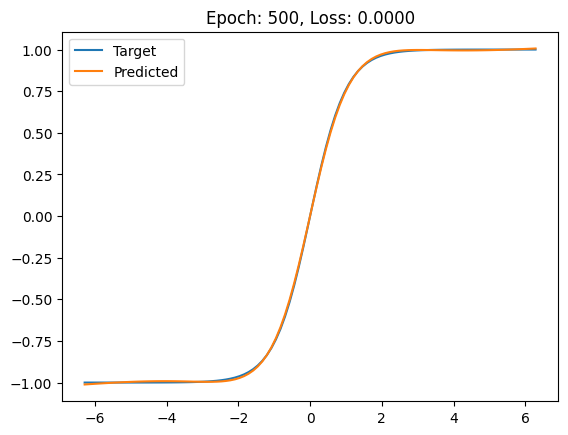

Epoch [600/1000], Loss: 0.0001


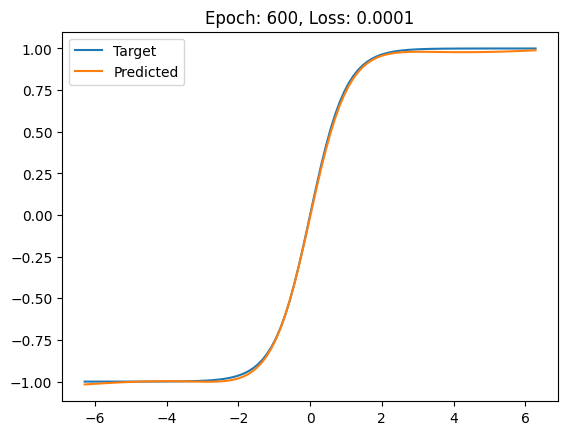

Epoch [700/1000], Loss: 0.0000


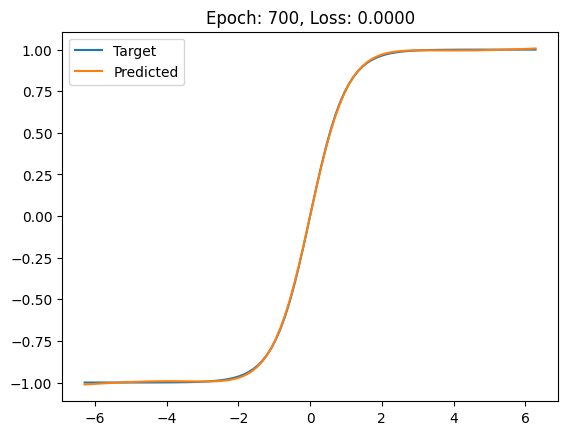

Epoch [800/1000], Loss: 0.0002


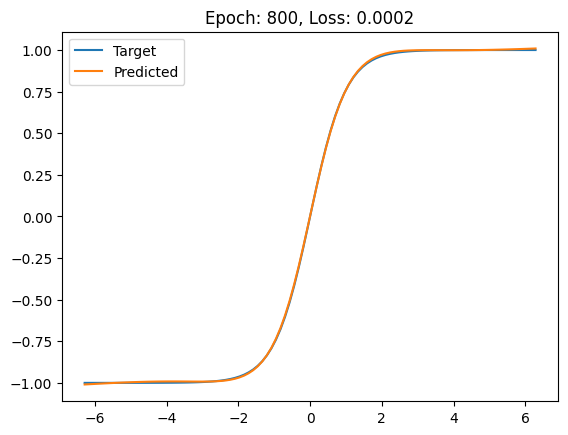

Epoch [900/1000], Loss: 0.0000


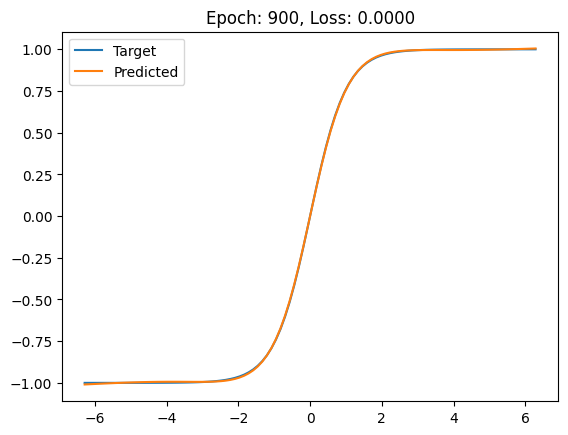

Epoch [1000/1000], Loss: 0.0024


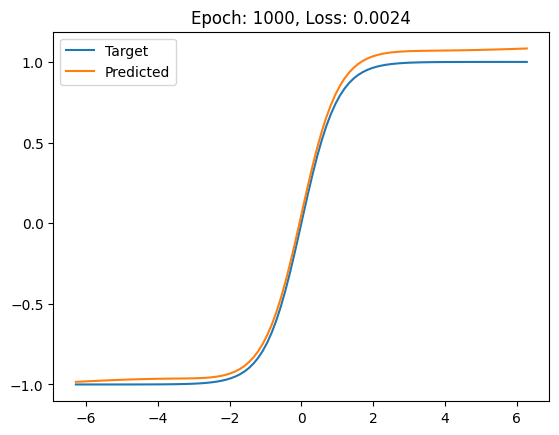

In [99]:
fit_function(np.tanh,num_epochs=1000)

square函数

Epoch [100/1000], Loss: 103.8425


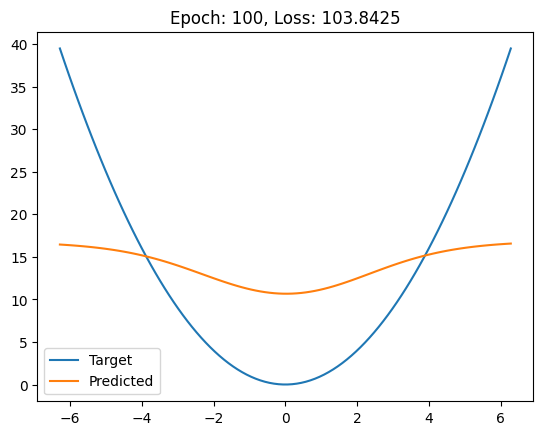

Epoch [200/1000], Loss: 41.8489


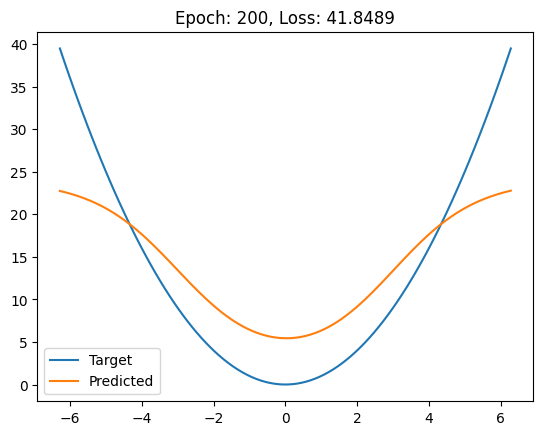

Epoch [300/1000], Loss: 11.4424


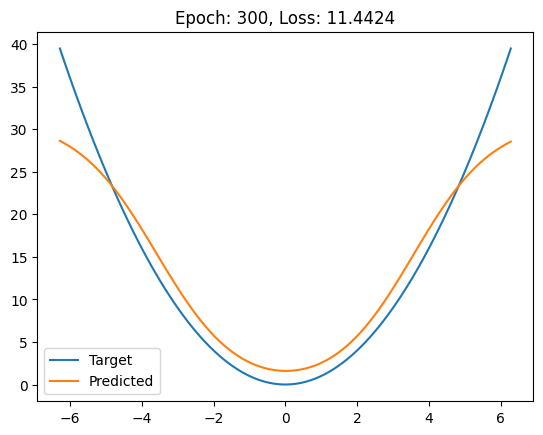

Epoch [400/1000], Loss: 3.7549


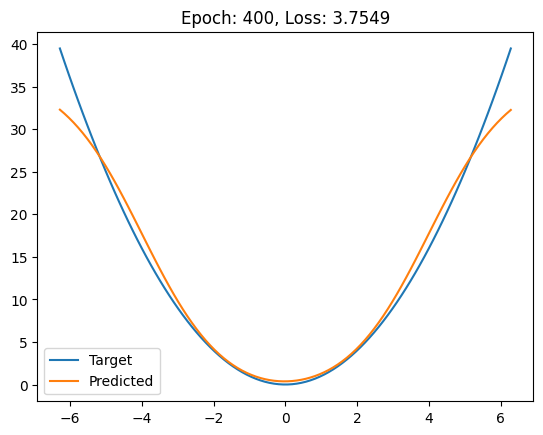

Epoch [500/1000], Loss: 1.7631


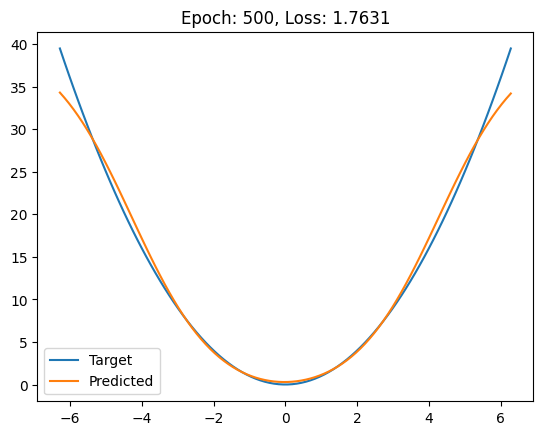

Epoch [600/1000], Loss: 1.0392


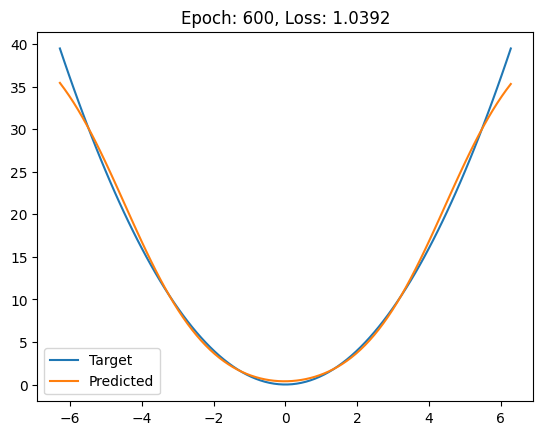

Epoch [700/1000], Loss: 0.7158


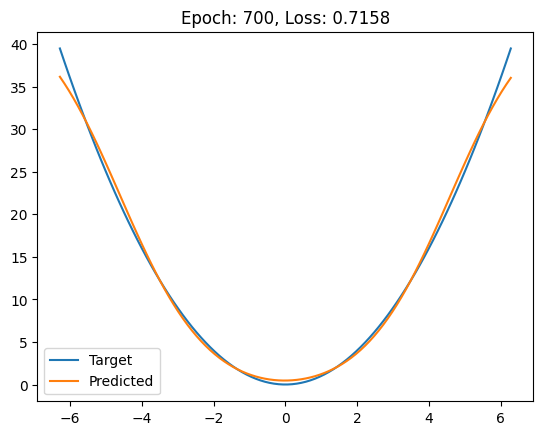

Epoch [800/1000], Loss: 0.5507


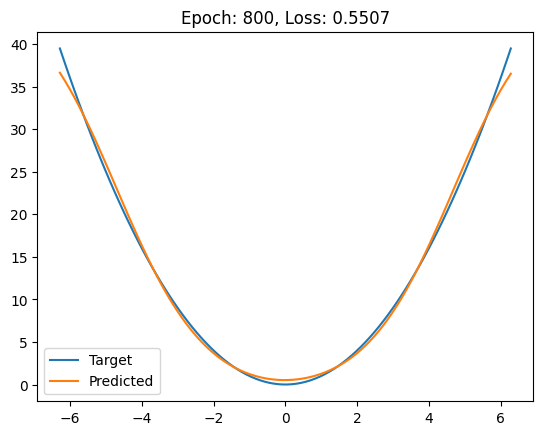

Epoch [900/1000], Loss: 0.4528


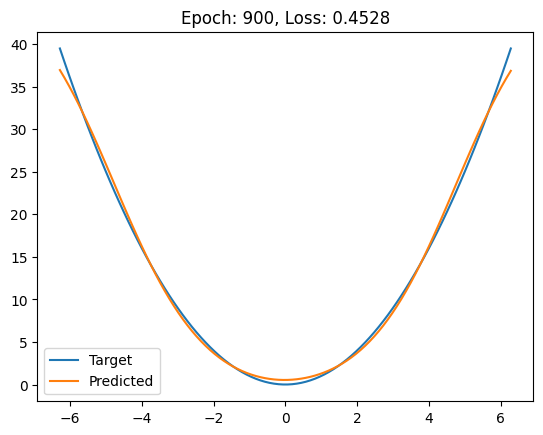

Epoch [1000/1000], Loss: 0.3741


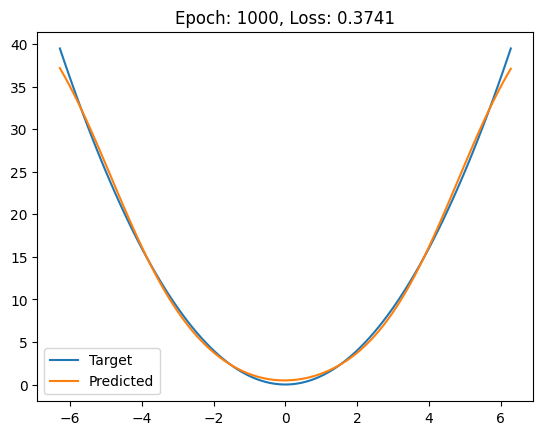

In [100]:
fit_function(np.square,num_epochs=1000)

abs函数

Epoch [100/1000], Loss: 0.4268


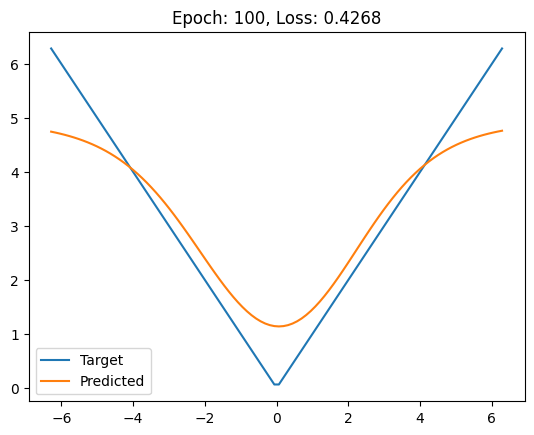

Epoch [200/1000], Loss: 0.0350


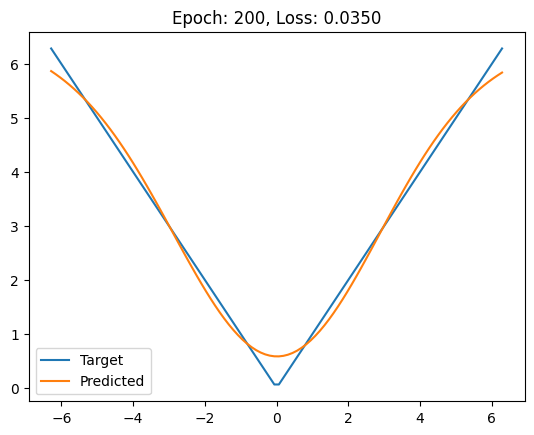

Epoch [300/1000], Loss: 0.0232


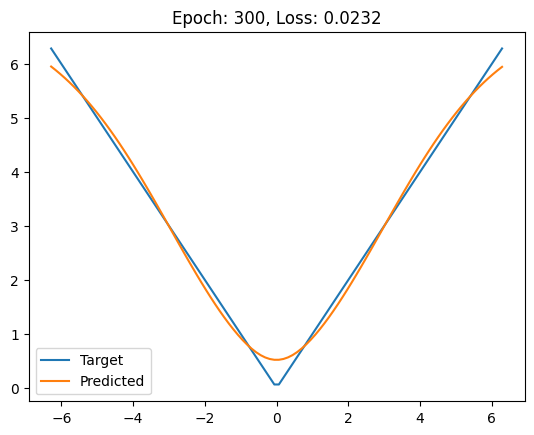

Epoch [400/1000], Loss: 0.0133


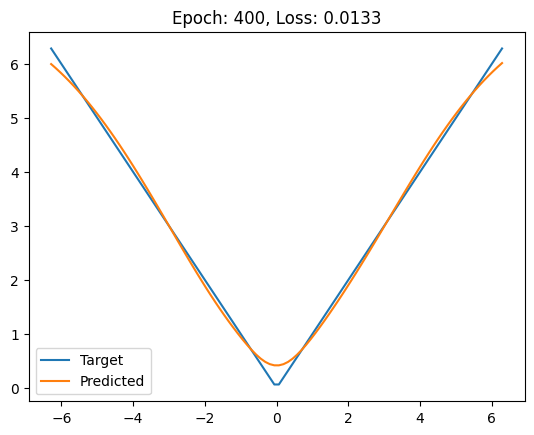

Epoch [500/1000], Loss: 0.0064


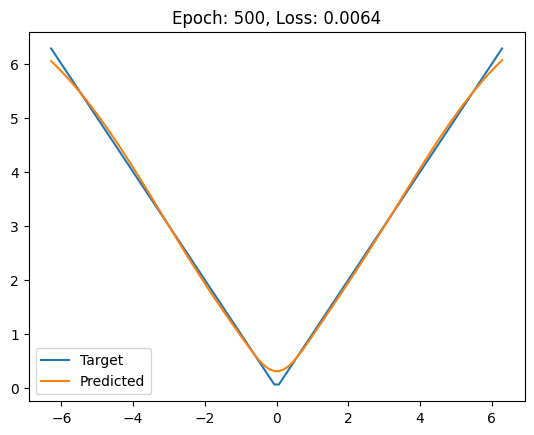

Epoch [600/1000], Loss: 0.0031


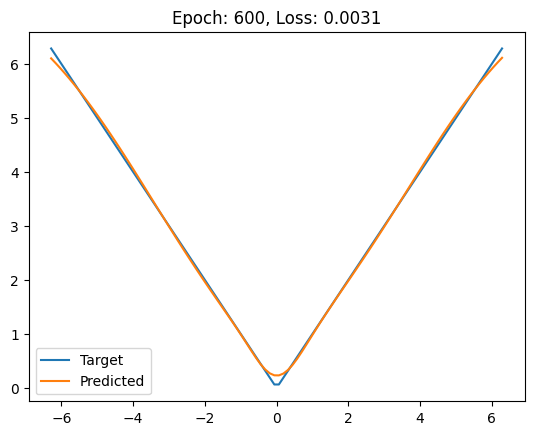

Epoch [700/1000], Loss: 0.0019


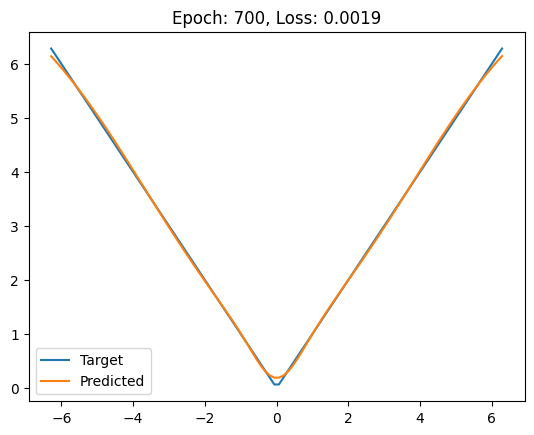

Epoch [800/1000], Loss: 0.0014


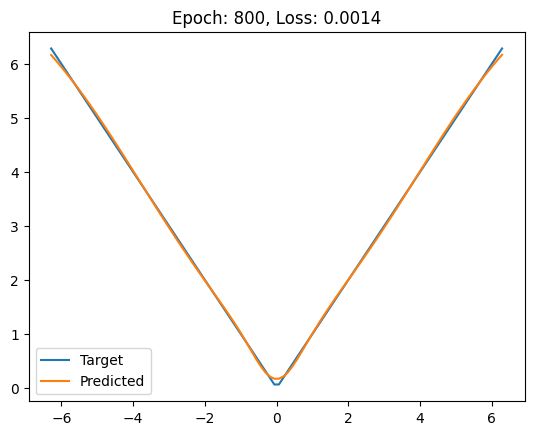

Epoch [900/1000], Loss: 0.0012


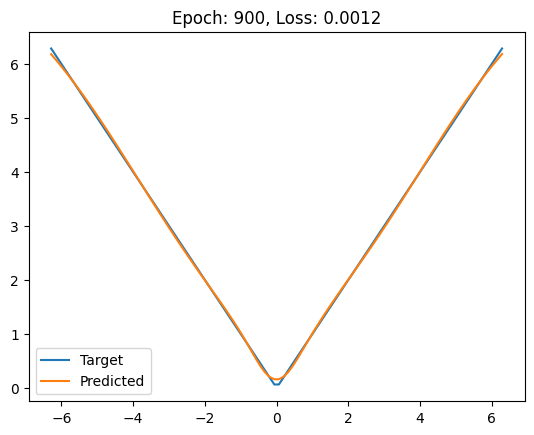

Epoch [1000/1000], Loss: 0.0011


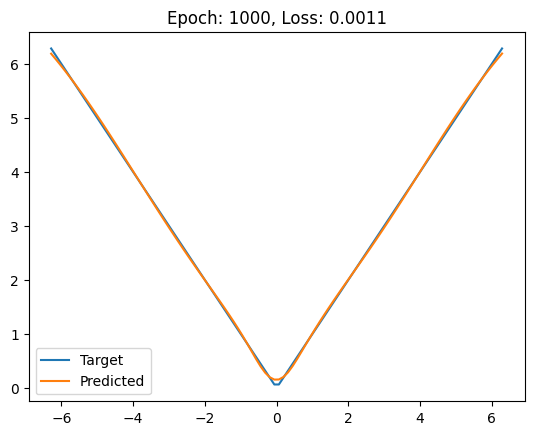

In [101]:
fit_function(np.abs,num_epochs=1000)

### 上面是基于numpy的内置的数学基本函数，下面我们尝试自己设计的函数。
查看拟合效果

Epoch [100/2000], Loss: 99.0246


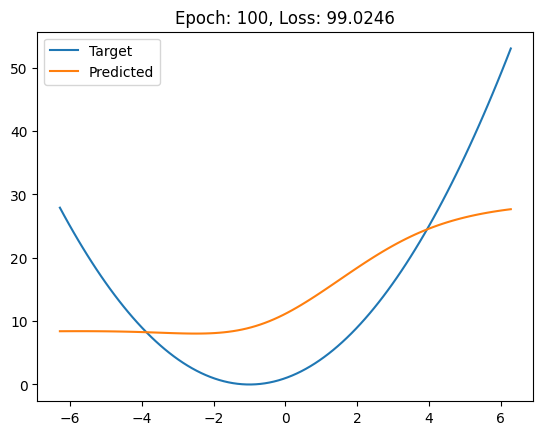

Epoch [200/2000], Loss: 28.8931


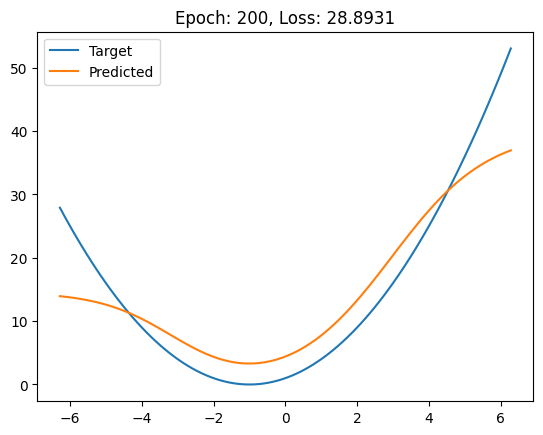

Epoch [300/2000], Loss: 6.8016


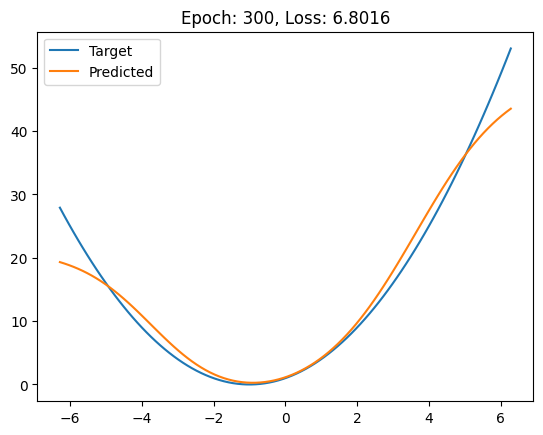

Epoch [400/2000], Loss: 2.6840


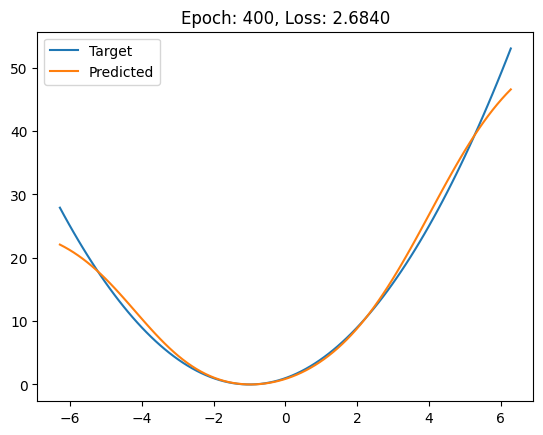

Epoch [500/2000], Loss: 1.4055


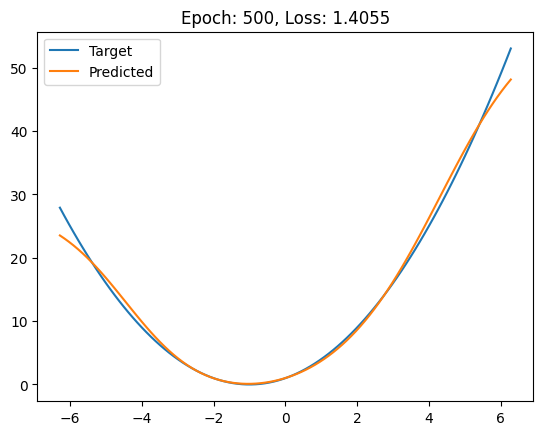

Epoch [600/2000], Loss: 0.8611


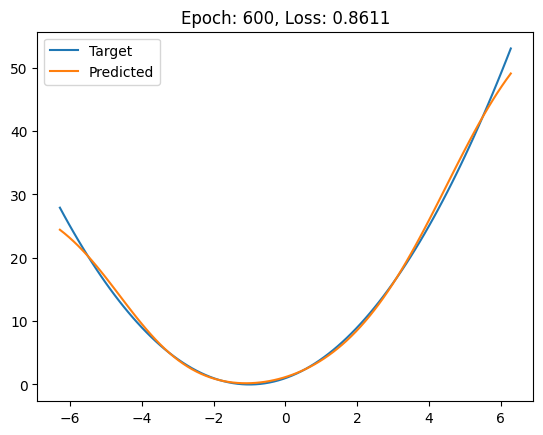

Epoch [700/2000], Loss: 0.5959


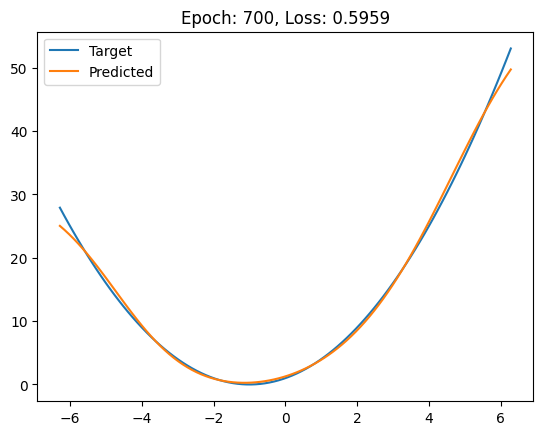

Epoch [800/2000], Loss: 0.4549


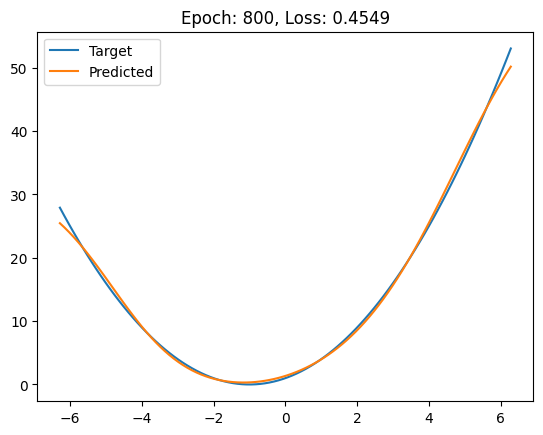

Epoch [900/2000], Loss: 0.3724


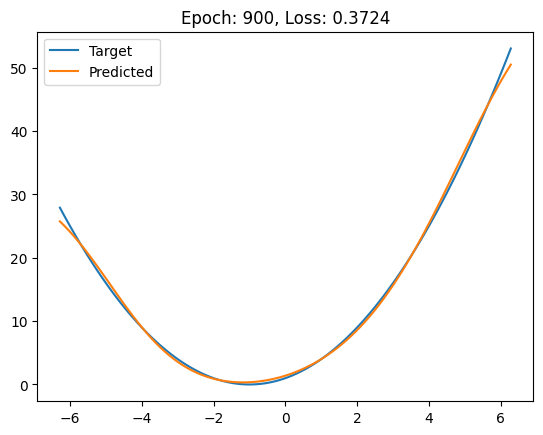

Epoch [1000/2000], Loss: 0.3173


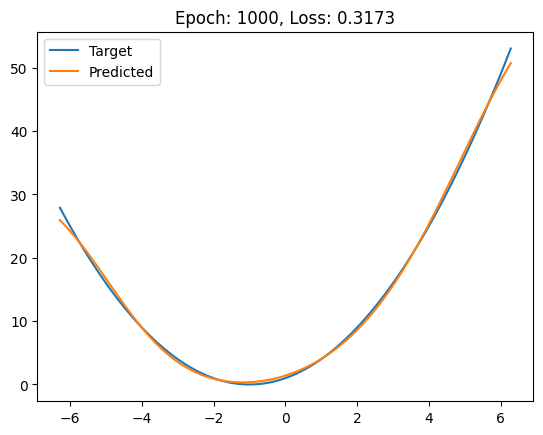

Epoch [1100/2000], Loss: 0.2709


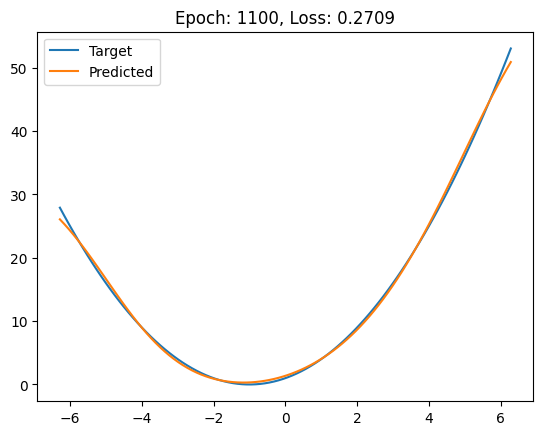

Epoch [1200/2000], Loss: 0.2144


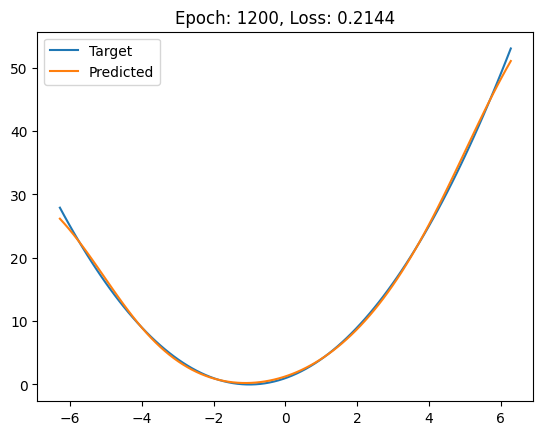

Epoch [1300/2000], Loss: 0.1644


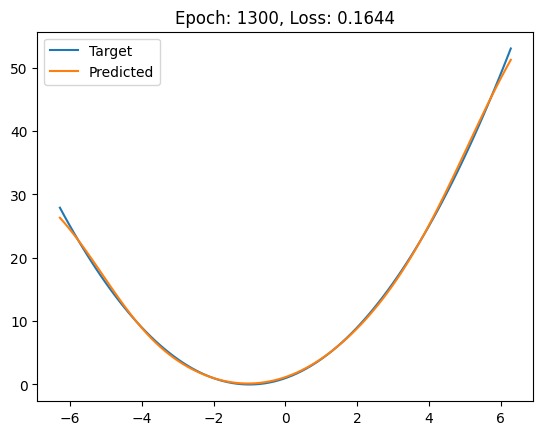

Epoch [1400/2000], Loss: 0.1340


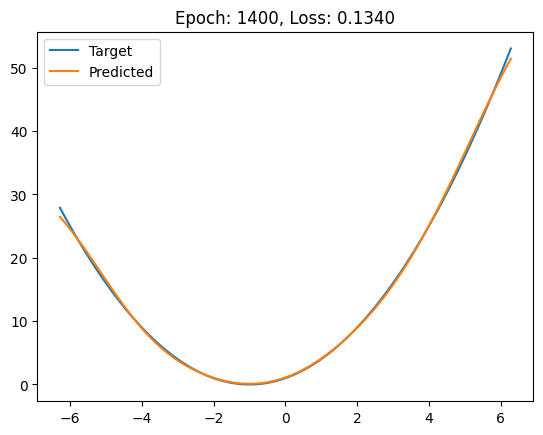

Epoch [1500/2000], Loss: 0.1145


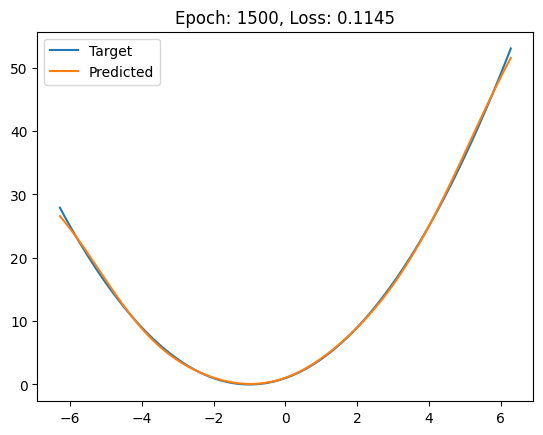

Epoch [1600/2000], Loss: 0.0998


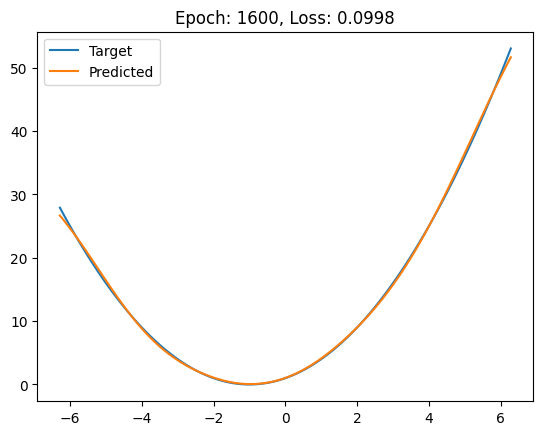

Epoch [1700/2000], Loss: 0.0876


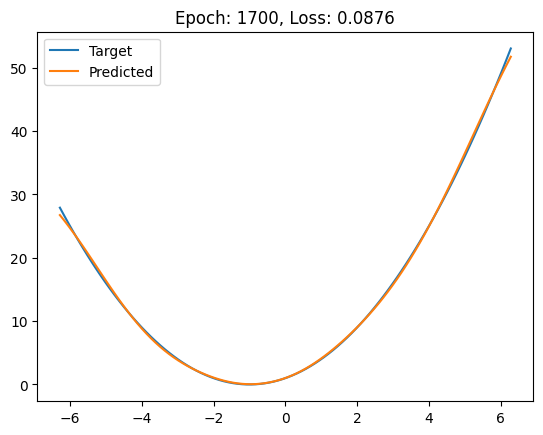

Epoch [1800/2000], Loss: 0.0769


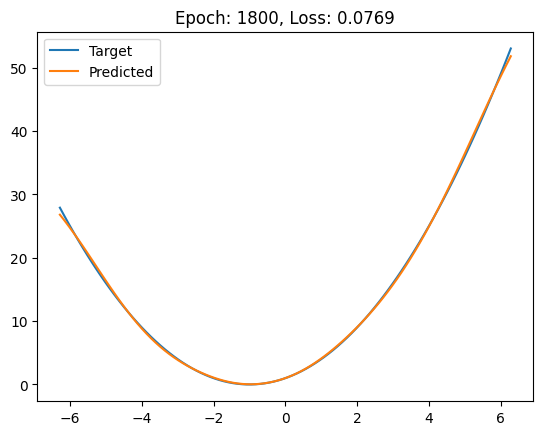

Epoch [1900/2000], Loss: 0.0677


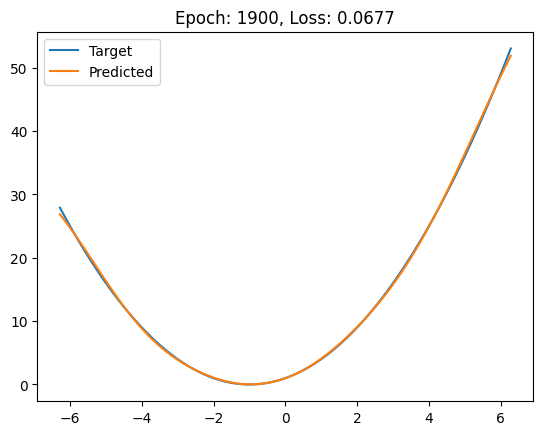

Epoch [2000/2000], Loss: 0.0599


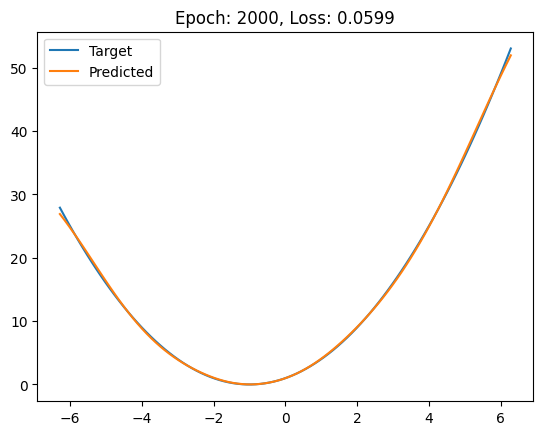

In [102]:
import numpy as np
# 自定义目标函数：二次函数
def quadratic_func(x):
    return x**2 + 2*x + 1
# 使用封装函数拟合二次函数
fit_function(quadratic_func)

我们可以看到我们设计的简单的两层神经网络函数，可以拟合自定义和numpy内嵌的很多函数。我们可以把这个函数封装成一个函数，以后我们要拟合函数，只需要传入函数名就可以了。

## 扩展四、探究数据量对神经网络了拟合效果的影响
我们知道影响神经网络性能的很多因素，比如模型的结构，模型的超参数，还有模型一些优化等等函数的设计。但是我们在实际应用中，我们发现数据量对神经网络的性能影响很大。我们在这里探究数据量对神经网络的影响。之前的函数我们采样很多数据点，我们在这里减少数据点，看看数据量对神经网络的影响。

epoch 20: Loss = 0.3417
epoch 40: Loss = 0.2826
epoch 60: Loss = 0.2593
epoch 80: Loss = 0.2495
epoch 100: Loss = 0.2447
epoch 120: Loss = 0.2419
epoch 140: Loss = 0.2397
epoch 160: Loss = 0.2379
epoch 180: Loss = 0.2363
epoch 200: Loss = 0.2347
epoch 220: Loss = 0.2332
epoch 240: Loss = 0.2317
epoch 260: Loss = 0.2302
epoch 280: Loss = 0.2288
epoch 300: Loss = 0.2274
epoch 320: Loss = 0.2260
epoch 340: Loss = 0.2247
epoch 360: Loss = 0.2234
epoch 380: Loss = 0.2221
epoch 400: Loss = 0.2208
epoch 420: Loss = 0.2196
epoch 440: Loss = 0.2184
epoch 460: Loss = 0.2172
epoch 480: Loss = 0.2160
epoch 500: Loss = 0.2149
epoch 520: Loss = 0.2138
epoch 540: Loss = 0.2127
epoch 560: Loss = 0.2116
epoch 580: Loss = 0.2106
epoch 600: Loss = 0.2096
epoch 620: Loss = 0.2085
epoch 640: Loss = 0.2075
epoch 660: Loss = 0.2066
epoch 680: Loss = 0.2056
epoch 700: Loss = 0.2047
epoch 720: Loss = 0.2037
epoch 740: Loss = 0.2028
epoch 760: Loss = 0.2019
epoch 780: Loss = 0.2011
epoch 800: Loss = 0.2002
epoc

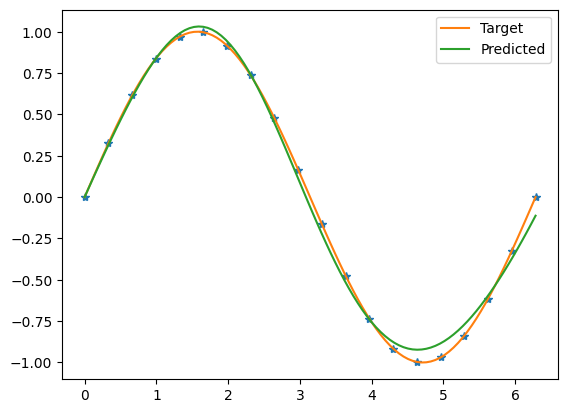

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# 生成数据
x = np.linspace(0, 2*np.pi, 20).reshape((-1,1))
y = np.sin(x)
# 转换为Tensor
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()
# 定义模型
model = nn.Sequential(
    nn.Linear(1, 100),
    nn.Sigmoid(),
    nn.Linear(100, 1)
)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
# 训练模型
num_epochs = 100000
for epoch in range(num_epochs):
    # 前向传播
    outputs = model(x_tensor)
    loss = criterion(outputs, y_tensor)
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 19:
        print('epoch {}: Loss = {:.4f}'.format(epoch+1, loss.item()))
# 测试模型
model.eval()
with torch.no_grad():
    x_test = np.linspace(0, np.pi*2, 100).reshape((-1,1))
    x_test_tensor = torch.from_numpy(x_test).float()
    y_test_tensor = torch.sin(x_test_tensor)
    y_pred_tensor = model(x_test_tensor)
    y_pred = y_pred_tensor.numpy()
# 可视化结果
plt.plot(x, y, '*')
plt.plot(x_test, y_test_tensor, label='Target')
plt.plot(x_test, y_pred, label='Predicted')
plt.legend()
plt.show()

当前数据个数data_num: 5
epoch 200: Loss = 0.3034
epoch 400: Loss = 0.2905
epoch 600: Loss = 0.2796
epoch 800: Loss = 0.2701
epoch 1000: Loss = 0.2616


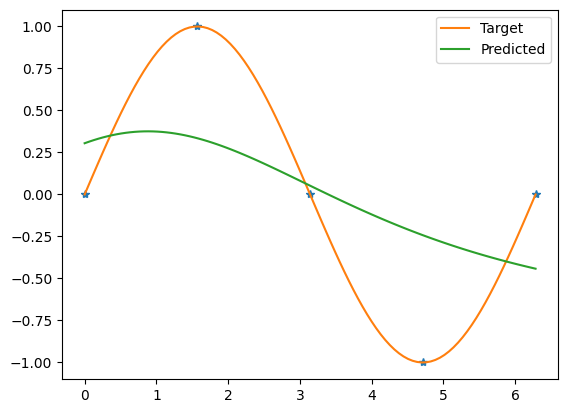

当前数据个数data_num: 15
epoch 200: Loss = 0.1914
epoch 400: Loss = 0.1851
epoch 600: Loss = 0.1795
epoch 800: Loss = 0.1743
epoch 1000: Loss = 0.1694


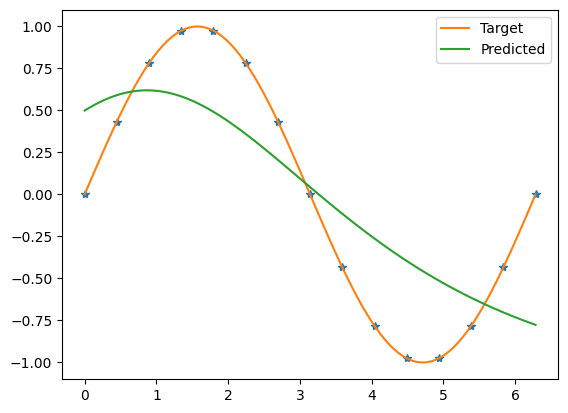

当前数据个数data_num: 25
epoch 200: Loss = 0.1525
epoch 400: Loss = 0.1485
epoch 600: Loss = 0.1448
epoch 800: Loss = 0.1411
epoch 1000: Loss = 0.1376


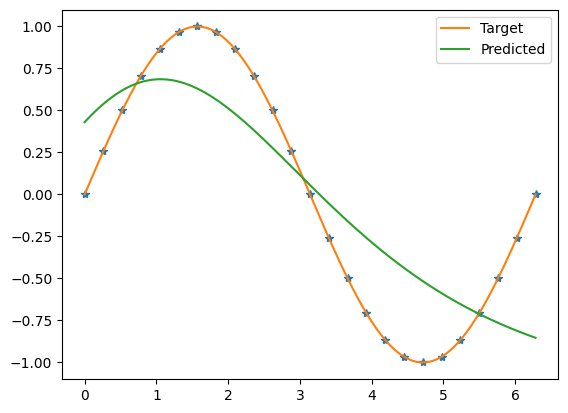

当前数据个数data_num: 35
epoch 200: Loss = 0.1293
epoch 400: Loss = 0.1262
epoch 600: Loss = 0.1231
epoch 800: Loss = 0.1201
epoch 1000: Loss = 0.1172


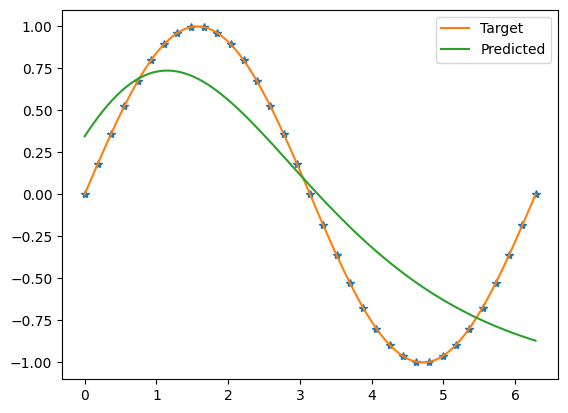

当前数据个数data_num: 45
epoch 200: Loss = 0.1119
epoch 400: Loss = 0.1092
epoch 600: Loss = 0.1065
epoch 800: Loss = 0.1040
epoch 1000: Loss = 0.1015


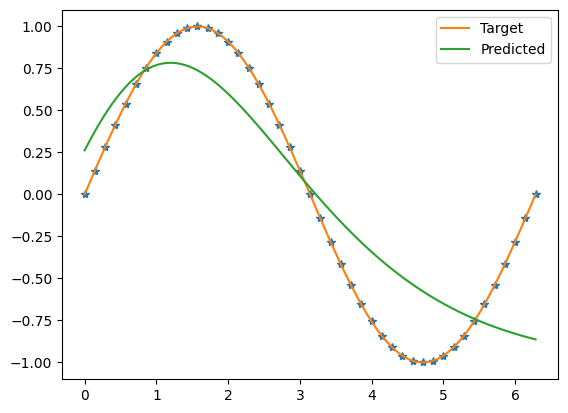

当前数据个数data_num: 55
epoch 200: Loss = 0.0977
epoch 400: Loss = 0.0954
epoch 600: Loss = 0.0931
epoch 800: Loss = 0.0910
epoch 1000: Loss = 0.0889


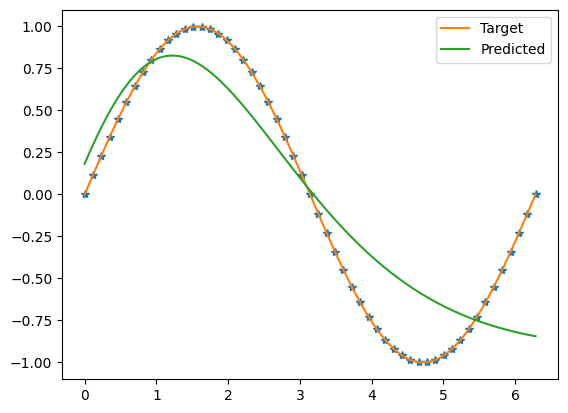

当前数据个数data_num: 65
epoch 200: Loss = 0.0860
epoch 400: Loss = 0.0841
epoch 600: Loss = 0.0823
epoch 800: Loss = 0.0805
epoch 1000: Loss = 0.0788


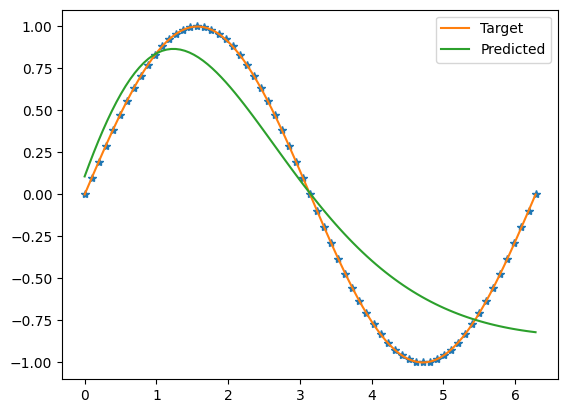

当前数据个数data_num: 75
epoch 200: Loss = 0.0766
epoch 400: Loss = 0.0751
epoch 600: Loss = 0.0736
epoch 800: Loss = 0.0722
epoch 1000: Loss = 0.0709


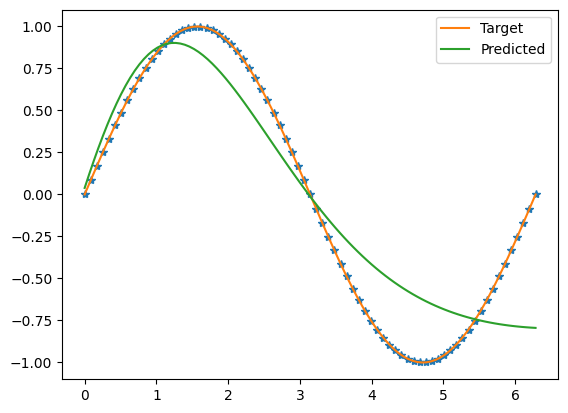

当前数据个数data_num: 85
epoch 200: Loss = 0.0692
epoch 400: Loss = 0.0679
epoch 600: Loss = 0.0668
epoch 800: Loss = 0.0657
epoch 1000: Loss = 0.0646


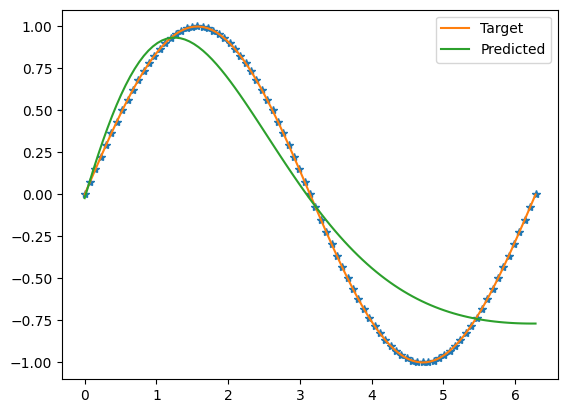

当前数据个数data_num: 95
epoch 200: Loss = 0.0633
epoch 400: Loss = 0.0623
epoch 600: Loss = 0.0614
epoch 800: Loss = 0.0606
epoch 1000: Loss = 0.0597


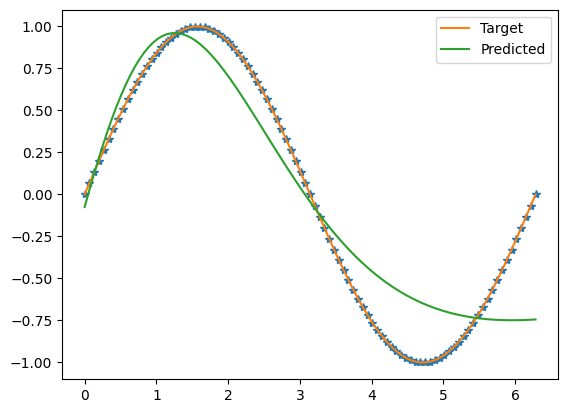

In [104]:
# 把上面的代码封装成一个函数，参数为数据的个数和训练轮数
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# 生成数据
x = np.linspace(0, 2*np.pi, 20).reshape((-1,1))
y = np.sin(x)
# 转换为Tensor
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()
# 定义模型
model = nn.Sequential(
    nn.Linear(1, 100),
    nn.Sigmoid(),
    nn.Linear(100, 1)
)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
# 训练模型
def train_model(model,num_epochs = 1000,data_num = 20):
    x = np.linspace(0, 2*np.pi, data_num).reshape((-1,1))
    y = np.sin(x)
    # 转换为Tensor
    x_tensor = torch.from_numpy(x).float()
    y_tensor = torch.from_numpy(y).float()
    # 定义损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    # 训练模型
    for epoch in range(num_epochs):
        # 前向传播
        outputs = model(x_tensor)
        loss = criterion(outputs, y_tensor)
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 200 == 199:
            print('epoch {}: Loss = {:.4f}'.format(epoch+1, loss.item()))
#训练结束画一张图
    model.eval()
    with torch.no_grad():
        x_test = np.linspace(0, np.pi*2, 100).reshape((-1,1))
        x_test_tensor = torch.from_numpy(x_test).float()
        y_test_tensor = torch.sin(x_test_tensor)
        y_pred_tensor = model(x_test_tensor)
        y_pred = y_pred_tensor.numpy()
    # 可视化结果
    plt.plot(x, y, '*')
    plt.plot(x_test, y_test_tensor, label='Target')
    plt.plot(x_test, y_pred, label='Predicted')
    plt.legend()
    plt.show()
for i in range(5,105,10):
    #输出当前数据个数，标记
    print("当前数据个数data_num:",i)
    train_model(model,num_epochs = 1000,data_num = i)

可以直观地看到数据越多效果越好。
我们研究一下少量数据情况下的拟合,我们只选5个点参加试验

当前训练个数num_epochs: 1000
epoch 200: Loss = 0.1021
epoch 400: Loss = 0.0960
epoch 600: Loss = 0.0924
epoch 800: Loss = 0.0895
epoch 1000: Loss = 0.0868


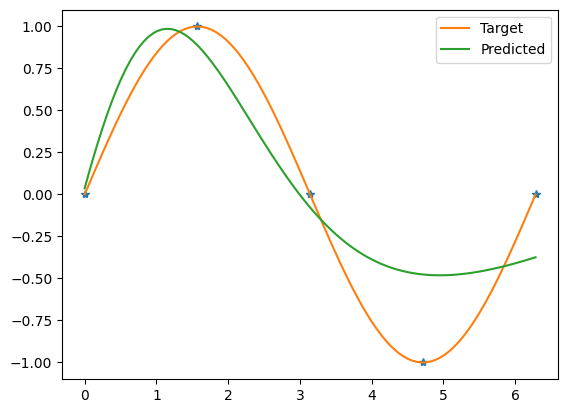

当前训练个数num_epochs: 3000
epoch 200: Loss = 0.0843
epoch 400: Loss = 0.0820
epoch 600: Loss = 0.0799
epoch 800: Loss = 0.0779
epoch 1000: Loss = 0.0761
epoch 1200: Loss = 0.0743
epoch 1400: Loss = 0.0727
epoch 1600: Loss = 0.0713
epoch 1800: Loss = 0.0699
epoch 2000: Loss = 0.0686
epoch 2200: Loss = 0.0674
epoch 2400: Loss = 0.0662
epoch 2600: Loss = 0.0652
epoch 2800: Loss = 0.0642
epoch 3000: Loss = 0.0633


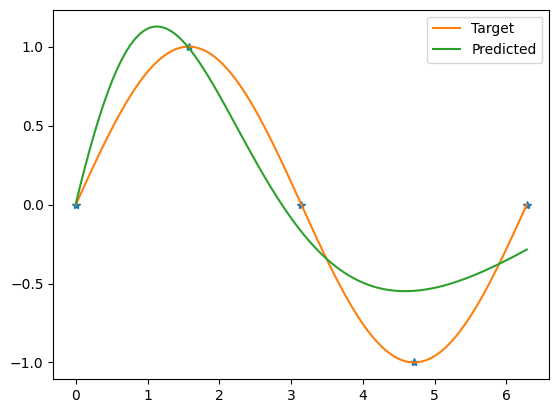

当前训练个数num_epochs: 5000
epoch 200: Loss = 0.0624
epoch 400: Loss = 0.0616
epoch 600: Loss = 0.0608
epoch 800: Loss = 0.0601
epoch 1000: Loss = 0.0594
epoch 1200: Loss = 0.0587
epoch 1400: Loss = 0.0581
epoch 1600: Loss = 0.0575
epoch 1800: Loss = 0.0569
epoch 2000: Loss = 0.0564
epoch 2200: Loss = 0.0559
epoch 2400: Loss = 0.0554
epoch 2600: Loss = 0.0549
epoch 2800: Loss = 0.0544
epoch 3000: Loss = 0.0539
epoch 3200: Loss = 0.0535
epoch 3400: Loss = 0.0530
epoch 3600: Loss = 0.0526
epoch 3800: Loss = 0.0522
epoch 4000: Loss = 0.0518
epoch 4200: Loss = 0.0514
epoch 4400: Loss = 0.0510
epoch 4600: Loss = 0.0507
epoch 4800: Loss = 0.0503
epoch 5000: Loss = 0.0499


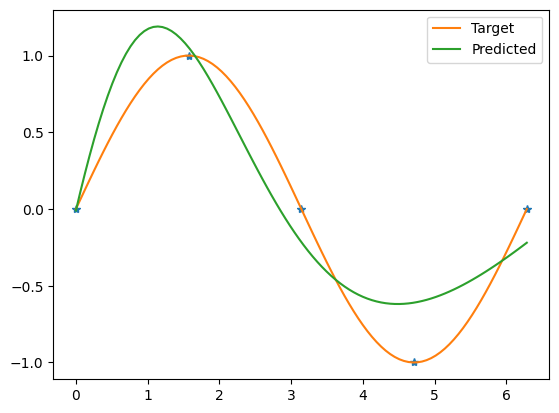

当前训练个数num_epochs: 7000
epoch 200: Loss = 0.0496
epoch 400: Loss = 0.0492
epoch 600: Loss = 0.0489
epoch 800: Loss = 0.0485
epoch 1000: Loss = 0.0482
epoch 1200: Loss = 0.0479
epoch 1400: Loss = 0.0476
epoch 1600: Loss = 0.0473
epoch 1800: Loss = 0.0470
epoch 2000: Loss = 0.0466
epoch 2200: Loss = 0.0463
epoch 2400: Loss = 0.0461
epoch 2600: Loss = 0.0458
epoch 2800: Loss = 0.0455
epoch 3000: Loss = 0.0452
epoch 3200: Loss = 0.0449
epoch 3400: Loss = 0.0446
epoch 3600: Loss = 0.0444
epoch 3800: Loss = 0.0441
epoch 4000: Loss = 0.0438
epoch 4200: Loss = 0.0436
epoch 4400: Loss = 0.0433
epoch 4600: Loss = 0.0430
epoch 4800: Loss = 0.0428
epoch 5000: Loss = 0.0425
epoch 5200: Loss = 0.0423
epoch 5400: Loss = 0.0420
epoch 5600: Loss = 0.0418
epoch 5800: Loss = 0.0415
epoch 6000: Loss = 0.0413
epoch 6200: Loss = 0.0411
epoch 6400: Loss = 0.0408
epoch 6600: Loss = 0.0406
epoch 6800: Loss = 0.0404
epoch 7000: Loss = 0.0401


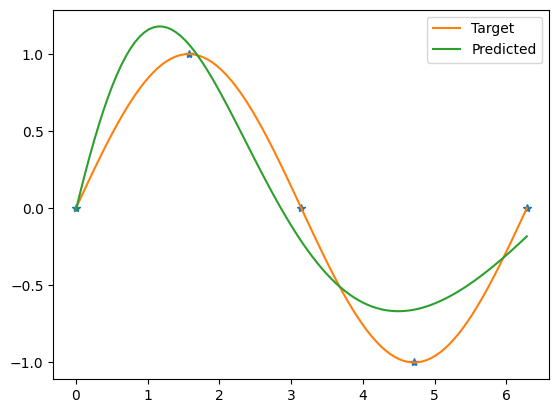

当前训练个数num_epochs: 9000
epoch 200: Loss = 0.0399
epoch 400: Loss = 0.0397
epoch 600: Loss = 0.0395
epoch 800: Loss = 0.0392
epoch 1000: Loss = 0.0390
epoch 1200: Loss = 0.0388
epoch 1400: Loss = 0.0386
epoch 1600: Loss = 0.0384
epoch 1800: Loss = 0.0382
epoch 2000: Loss = 0.0379
epoch 2200: Loss = 0.0377
epoch 2400: Loss = 0.0375
epoch 2600: Loss = 0.0373
epoch 2800: Loss = 0.0371
epoch 3000: Loss = 0.0369
epoch 3200: Loss = 0.0367
epoch 3400: Loss = 0.0365
epoch 3600: Loss = 0.0363
epoch 3800: Loss = 0.0361
epoch 4000: Loss = 0.0359
epoch 4200: Loss = 0.0357
epoch 4400: Loss = 0.0355
epoch 4600: Loss = 0.0353
epoch 4800: Loss = 0.0352
epoch 5000: Loss = 0.0350
epoch 5200: Loss = 0.0348
epoch 5400: Loss = 0.0346
epoch 5600: Loss = 0.0344
epoch 5800: Loss = 0.0342
epoch 6000: Loss = 0.0340
epoch 6200: Loss = 0.0339
epoch 6400: Loss = 0.0337
epoch 6600: Loss = 0.0335
epoch 6800: Loss = 0.0333
epoch 7000: Loss = 0.0331
epoch 7200: Loss = 0.0330
epoch 7400: Loss = 0.0328
epoch 7600: Loss = 

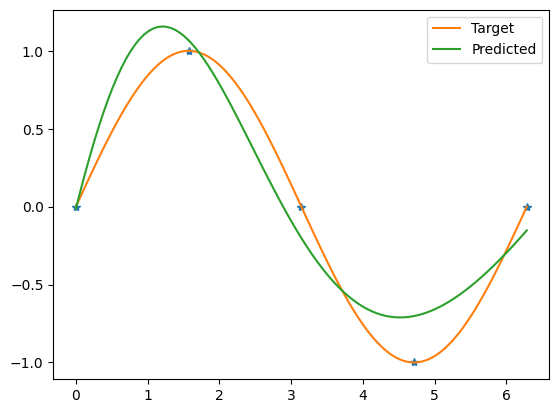

当前训练个数num_epochs: 11000
epoch 200: Loss = 0.0313
epoch 400: Loss = 0.0311
epoch 600: Loss = 0.0309
epoch 800: Loss = 0.0308
epoch 1000: Loss = 0.0306
epoch 1200: Loss = 0.0304
epoch 1400: Loss = 0.0303
epoch 1600: Loss = 0.0301
epoch 1800: Loss = 0.0300
epoch 2000: Loss = 0.0298
epoch 2200: Loss = 0.0297
epoch 2400: Loss = 0.0295
epoch 2600: Loss = 0.0293
epoch 2800: Loss = 0.0292
epoch 3000: Loss = 0.0290
epoch 3200: Loss = 0.0289
epoch 3400: Loss = 0.0287
epoch 3600: Loss = 0.0286
epoch 3800: Loss = 0.0284
epoch 4000: Loss = 0.0283
epoch 4200: Loss = 0.0281
epoch 4400: Loss = 0.0280
epoch 4600: Loss = 0.0278
epoch 4800: Loss = 0.0277
epoch 5000: Loss = 0.0275
epoch 5200: Loss = 0.0274
epoch 5400: Loss = 0.0272
epoch 5600: Loss = 0.0271
epoch 5800: Loss = 0.0270
epoch 6000: Loss = 0.0268
epoch 6200: Loss = 0.0267
epoch 6400: Loss = 0.0265
epoch 6600: Loss = 0.0264
epoch 6800: Loss = 0.0262
epoch 7000: Loss = 0.0261
epoch 7200: Loss = 0.0260
epoch 7400: Loss = 0.0258
epoch 7600: Loss =

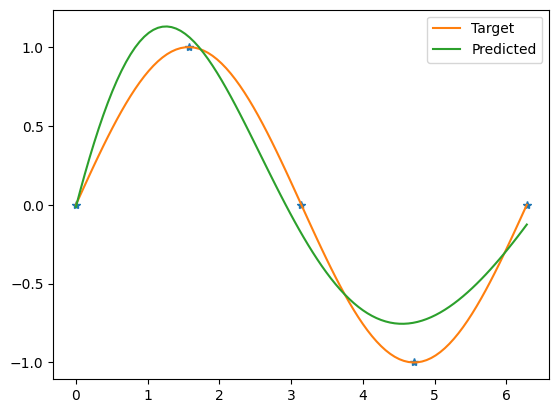

当前训练个数num_epochs: 13000
epoch 200: Loss = 0.0233
epoch 400: Loss = 0.0232
epoch 600: Loss = 0.0230
epoch 800: Loss = 0.0229
epoch 1000: Loss = 0.0228
epoch 1200: Loss = 0.0227
epoch 1400: Loss = 0.0225
epoch 1600: Loss = 0.0224
epoch 1800: Loss = 0.0223
epoch 2000: Loss = 0.0222
epoch 2200: Loss = 0.0220
epoch 2400: Loss = 0.0219
epoch 2600: Loss = 0.0218
epoch 2800: Loss = 0.0217
epoch 3000: Loss = 0.0215
epoch 3200: Loss = 0.0214
epoch 3400: Loss = 0.0213
epoch 3600: Loss = 0.0212
epoch 3800: Loss = 0.0211
epoch 4000: Loss = 0.0210
epoch 4200: Loss = 0.0208
epoch 4400: Loss = 0.0207
epoch 4600: Loss = 0.0206
epoch 4800: Loss = 0.0205
epoch 5000: Loss = 0.0204
epoch 5200: Loss = 0.0202
epoch 5400: Loss = 0.0201
epoch 5600: Loss = 0.0200
epoch 5800: Loss = 0.0199
epoch 6000: Loss = 0.0198
epoch 6200: Loss = 0.0197
epoch 6400: Loss = 0.0196
epoch 6600: Loss = 0.0194
epoch 6800: Loss = 0.0193
epoch 7000: Loss = 0.0192
epoch 7200: Loss = 0.0191
epoch 7400: Loss = 0.0190
epoch 7600: Loss =

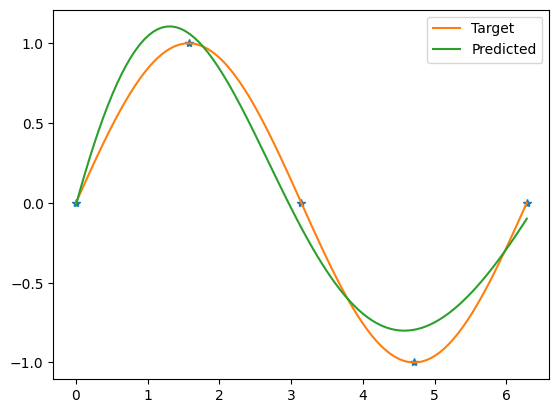

当前训练个数num_epochs: 15000
epoch 200: Loss = 0.0159
epoch 400: Loss = 0.0158
epoch 600: Loss = 0.0157
epoch 800: Loss = 0.0156
epoch 1000: Loss = 0.0156
epoch 1200: Loss = 0.0155
epoch 1400: Loss = 0.0154
epoch 1600: Loss = 0.0153
epoch 1800: Loss = 0.0152
epoch 2000: Loss = 0.0151
epoch 2200: Loss = 0.0150
epoch 2400: Loss = 0.0149
epoch 2600: Loss = 0.0148
epoch 2800: Loss = 0.0147
epoch 3000: Loss = 0.0146
epoch 3200: Loss = 0.0145
epoch 3400: Loss = 0.0144
epoch 3600: Loss = 0.0143
epoch 3800: Loss = 0.0142
epoch 4000: Loss = 0.0141
epoch 4200: Loss = 0.0140
epoch 4400: Loss = 0.0139
epoch 4600: Loss = 0.0138
epoch 4800: Loss = 0.0138
epoch 5000: Loss = 0.0137
epoch 5200: Loss = 0.0136
epoch 5400: Loss = 0.0135
epoch 5600: Loss = 0.0134
epoch 5800: Loss = 0.0133
epoch 6000: Loss = 0.0132
epoch 6200: Loss = 0.0131
epoch 6400: Loss = 0.0130
epoch 6600: Loss = 0.0129
epoch 6800: Loss = 0.0129
epoch 7000: Loss = 0.0128
epoch 7200: Loss = 0.0127
epoch 7400: Loss = 0.0126
epoch 7600: Loss =

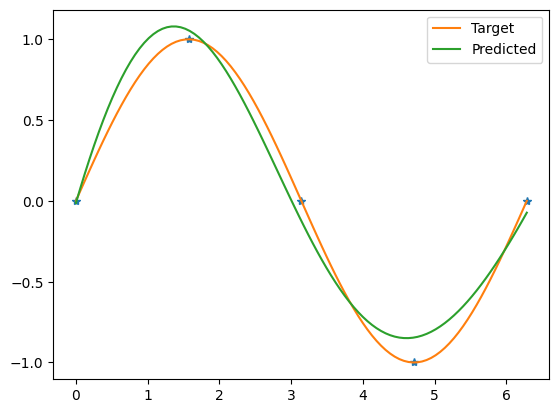

当前训练个数num_epochs: 17000
epoch 200: Loss = 0.0095
epoch 400: Loss = 0.0094
epoch 600: Loss = 0.0093
epoch 800: Loss = 0.0093
epoch 1000: Loss = 0.0092
epoch 1200: Loss = 0.0091
epoch 1400: Loss = 0.0091
epoch 1600: Loss = 0.0090
epoch 1800: Loss = 0.0089
epoch 2000: Loss = 0.0088
epoch 2200: Loss = 0.0088
epoch 2400: Loss = 0.0087
epoch 2600: Loss = 0.0086
epoch 2800: Loss = 0.0086
epoch 3000: Loss = 0.0085
epoch 3200: Loss = 0.0084
epoch 3400: Loss = 0.0084
epoch 3600: Loss = 0.0083
epoch 3800: Loss = 0.0082
epoch 4000: Loss = 0.0082
epoch 4200: Loss = 0.0081
epoch 4400: Loss = 0.0080
epoch 4600: Loss = 0.0080
epoch 4800: Loss = 0.0079
epoch 5000: Loss = 0.0078
epoch 5200: Loss = 0.0078
epoch 5400: Loss = 0.0077
epoch 5600: Loss = 0.0076
epoch 5800: Loss = 0.0076
epoch 6000: Loss = 0.0075
epoch 6200: Loss = 0.0074
epoch 6400: Loss = 0.0074
epoch 6600: Loss = 0.0073
epoch 6800: Loss = 0.0073
epoch 7000: Loss = 0.0072
epoch 7200: Loss = 0.0071
epoch 7400: Loss = 0.0071
epoch 7600: Loss =

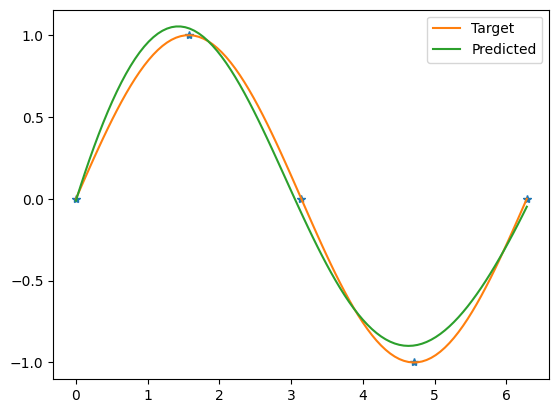

当前训练个数num_epochs: 19000
epoch 200: Loss = 0.0045
epoch 400: Loss = 0.0044
epoch 600: Loss = 0.0044
epoch 800: Loss = 0.0043
epoch 1000: Loss = 0.0043
epoch 1200: Loss = 0.0043
epoch 1400: Loss = 0.0042
epoch 1600: Loss = 0.0042
epoch 1800: Loss = 0.0041
epoch 2000: Loss = 0.0041
epoch 2200: Loss = 0.0040
epoch 2400: Loss = 0.0040
epoch 2600: Loss = 0.0040
epoch 2800: Loss = 0.0039
epoch 3000: Loss = 0.0039
epoch 3200: Loss = 0.0038
epoch 3400: Loss = 0.0038
epoch 3600: Loss = 0.0038
epoch 3800: Loss = 0.0037
epoch 4000: Loss = 0.0037
epoch 4200: Loss = 0.0036
epoch 4400: Loss = 0.0036
epoch 4600: Loss = 0.0036
epoch 4800: Loss = 0.0035
epoch 5000: Loss = 0.0035
epoch 5200: Loss = 0.0035
epoch 5400: Loss = 0.0034
epoch 5600: Loss = 0.0034
epoch 5800: Loss = 0.0033
epoch 6000: Loss = 0.0033
epoch 6200: Loss = 0.0033
epoch 6400: Loss = 0.0032
epoch 6600: Loss = 0.0032
epoch 6800: Loss = 0.0032
epoch 7000: Loss = 0.0031
epoch 7200: Loss = 0.0031
epoch 7400: Loss = 0.0031
epoch 7600: Loss =

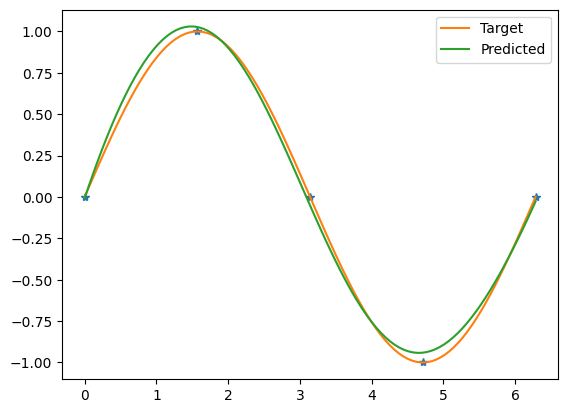

当前训练个数num_epochs: 21000
epoch 200: Loss = 0.0015
epoch 400: Loss = 0.0015
epoch 600: Loss = 0.0015
epoch 800: Loss = 0.0015
epoch 1000: Loss = 0.0014
epoch 1200: Loss = 0.0014
epoch 1400: Loss = 0.0014
epoch 1600: Loss = 0.0014
epoch 1800: Loss = 0.0014
epoch 2000: Loss = 0.0014
epoch 2200: Loss = 0.0013
epoch 2400: Loss = 0.0013
epoch 2600: Loss = 0.0013
epoch 2800: Loss = 0.0013
epoch 3000: Loss = 0.0013
epoch 3200: Loss = 0.0012
epoch 3400: Loss = 0.0012
epoch 3600: Loss = 0.0012
epoch 3800: Loss = 0.0012
epoch 4000: Loss = 0.0012
epoch 4200: Loss = 0.0012
epoch 4400: Loss = 0.0012
epoch 4600: Loss = 0.0011
epoch 4800: Loss = 0.0011
epoch 5000: Loss = 0.0011
epoch 5200: Loss = 0.0011
epoch 5400: Loss = 0.0011
epoch 5600: Loss = 0.0011
epoch 5800: Loss = 0.0011
epoch 6000: Loss = 0.0010
epoch 6200: Loss = 0.0010
epoch 6400: Loss = 0.0010
epoch 6600: Loss = 0.0010
epoch 6800: Loss = 0.0010
epoch 7000: Loss = 0.0010
epoch 7200: Loss = 0.0010
epoch 7400: Loss = 0.0009
epoch 7600: Loss =

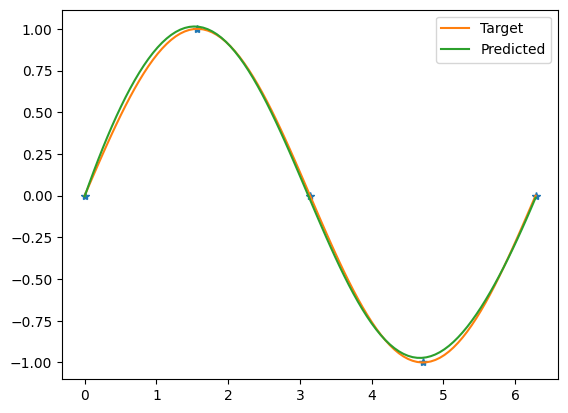

当前训练个数num_epochs: 23000
epoch 200: Loss = 0.0003
epoch 400: Loss = 0.0003
epoch 600: Loss = 0.0003
epoch 800: Loss = 0.0003
epoch 1000: Loss = 0.0003
epoch 1200: Loss = 0.0003
epoch 1400: Loss = 0.0003
epoch 1600: Loss = 0.0003
epoch 1800: Loss = 0.0003
epoch 2000: Loss = 0.0003
epoch 2200: Loss = 0.0003
epoch 2400: Loss = 0.0003
epoch 2600: Loss = 0.0003
epoch 2800: Loss = 0.0003
epoch 3000: Loss = 0.0003
epoch 3200: Loss = 0.0003
epoch 3400: Loss = 0.0003
epoch 3600: Loss = 0.0003
epoch 3800: Loss = 0.0003
epoch 4000: Loss = 0.0003
epoch 4200: Loss = 0.0003
epoch 4400: Loss = 0.0003
epoch 4600: Loss = 0.0002
epoch 4800: Loss = 0.0002
epoch 5000: Loss = 0.0002
epoch 5200: Loss = 0.0002
epoch 5400: Loss = 0.0002
epoch 5600: Loss = 0.0002
epoch 5800: Loss = 0.0002
epoch 6000: Loss = 0.0002
epoch 6200: Loss = 0.0002
epoch 6400: Loss = 0.0002
epoch 6600: Loss = 0.0002
epoch 6800: Loss = 0.0002
epoch 7000: Loss = 0.0002
epoch 7200: Loss = 0.0002
epoch 7400: Loss = 0.0002
epoch 7600: Loss =

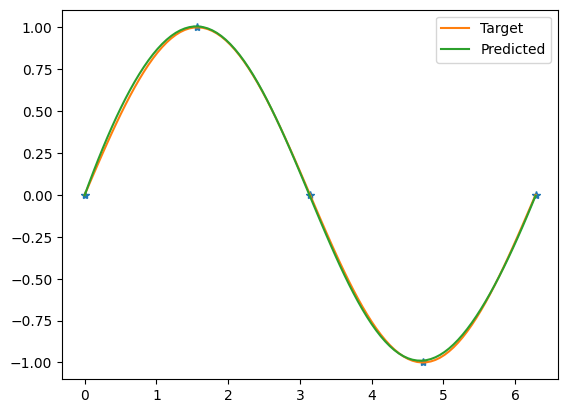

当前训练个数num_epochs: 25000
epoch 200: Loss = 0.0001
epoch 400: Loss = 0.0001
epoch 600: Loss = 0.0001
epoch 800: Loss = 0.0001
epoch 1000: Loss = 0.0001
epoch 1200: Loss = 0.0001
epoch 1400: Loss = 0.0001
epoch 1600: Loss = 0.0001
epoch 1800: Loss = 0.0000
epoch 2000: Loss = 0.0000
epoch 2200: Loss = 0.0000
epoch 2400: Loss = 0.0000
epoch 2600: Loss = 0.0000
epoch 2800: Loss = 0.0000
epoch 3000: Loss = 0.0000
epoch 3200: Loss = 0.0000
epoch 3400: Loss = 0.0000
epoch 3600: Loss = 0.0000
epoch 3800: Loss = 0.0000
epoch 4000: Loss = 0.0000
epoch 4200: Loss = 0.0000
epoch 4400: Loss = 0.0000
epoch 4600: Loss = 0.0000
epoch 4800: Loss = 0.0000
epoch 5000: Loss = 0.0000
epoch 5200: Loss = 0.0000
epoch 5400: Loss = 0.0000
epoch 5600: Loss = 0.0000
epoch 5800: Loss = 0.0000
epoch 6000: Loss = 0.0000
epoch 6200: Loss = 0.0000
epoch 6400: Loss = 0.0000
epoch 6600: Loss = 0.0000
epoch 6800: Loss = 0.0000
epoch 7000: Loss = 0.0000
epoch 7200: Loss = 0.0000
epoch 7400: Loss = 0.0000
epoch 7600: Loss =

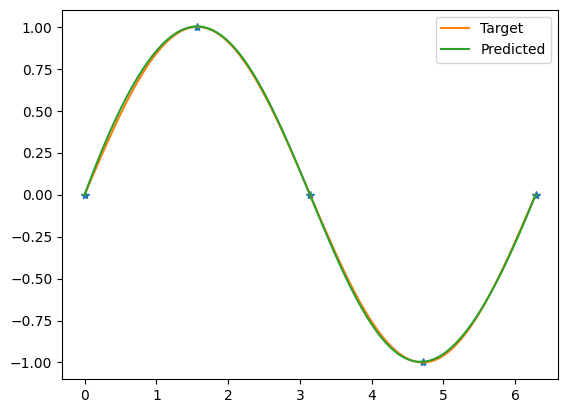

当前训练个数num_epochs: 27000
epoch 200: Loss = 0.0000
epoch 400: Loss = 0.0000
epoch 600: Loss = 0.0000
epoch 800: Loss = 0.0000
epoch 1000: Loss = 0.0000
epoch 1200: Loss = 0.0000
epoch 1400: Loss = 0.0000
epoch 1600: Loss = 0.0000
epoch 1800: Loss = 0.0000
epoch 2000: Loss = 0.0000
epoch 2200: Loss = 0.0000
epoch 2400: Loss = 0.0000
epoch 2600: Loss = 0.0000
epoch 2800: Loss = 0.0000
epoch 3000: Loss = 0.0000
epoch 3200: Loss = 0.0000
epoch 3400: Loss = 0.0000
epoch 3600: Loss = 0.0000
epoch 3800: Loss = 0.0000
epoch 4000: Loss = 0.0000
epoch 4200: Loss = 0.0000
epoch 4400: Loss = 0.0000
epoch 4600: Loss = 0.0000
epoch 4800: Loss = 0.0000
epoch 5000: Loss = 0.0000
epoch 5200: Loss = 0.0000
epoch 5400: Loss = 0.0000
epoch 5600: Loss = 0.0000
epoch 5800: Loss = 0.0000
epoch 6000: Loss = 0.0000
epoch 6200: Loss = 0.0000
epoch 6400: Loss = 0.0000
epoch 6600: Loss = 0.0000
epoch 6800: Loss = 0.0000
epoch 7000: Loss = 0.0000
epoch 7200: Loss = 0.0000
epoch 7400: Loss = 0.0000
epoch 7600: Loss =

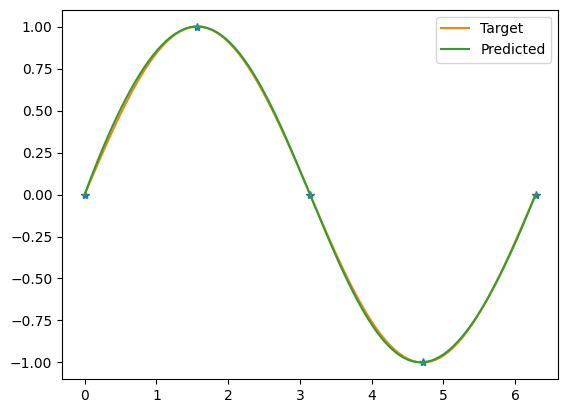

当前训练个数num_epochs: 29000
epoch 200: Loss = 0.0000
epoch 400: Loss = 0.0000
epoch 600: Loss = 0.0000
epoch 800: Loss = 0.0000
epoch 1000: Loss = 0.0000
epoch 1200: Loss = 0.0000
epoch 1400: Loss = 0.0000
epoch 1600: Loss = 0.0000
epoch 1800: Loss = 0.0000
epoch 2000: Loss = 0.0000
epoch 2200: Loss = 0.0000
epoch 2400: Loss = 0.0000
epoch 2600: Loss = 0.0000
epoch 2800: Loss = 0.0000
epoch 3000: Loss = 0.0000
epoch 3200: Loss = 0.0000
epoch 3400: Loss = 0.0000
epoch 3600: Loss = 0.0000
epoch 3800: Loss = 0.0000
epoch 4000: Loss = 0.0000
epoch 4200: Loss = 0.0000
epoch 4400: Loss = 0.0000
epoch 4600: Loss = 0.0000
epoch 4800: Loss = 0.0000
epoch 5000: Loss = 0.0000
epoch 5200: Loss = 0.0000
epoch 5400: Loss = 0.0000
epoch 5600: Loss = 0.0000
epoch 5800: Loss = 0.0000
epoch 6000: Loss = 0.0000
epoch 6200: Loss = 0.0000
epoch 6400: Loss = 0.0000
epoch 6600: Loss = 0.0000
epoch 6800: Loss = 0.0000
epoch 7000: Loss = 0.0000
epoch 7200: Loss = 0.0000
epoch 7400: Loss = 0.0000
epoch 7600: Loss =

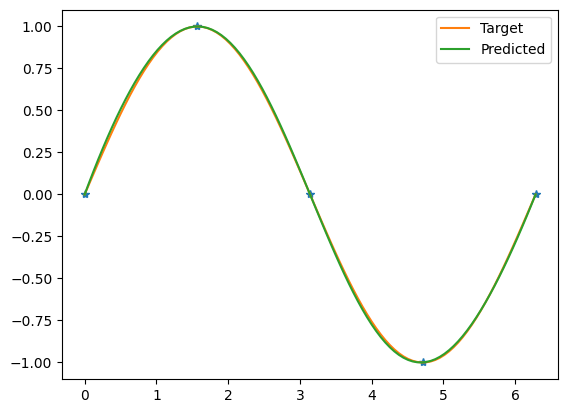

当前训练个数num_epochs: 31000
epoch 200: Loss = 0.0000
epoch 400: Loss = 0.0000
epoch 600: Loss = 0.0000
epoch 800: Loss = 0.0000
epoch 1000: Loss = 0.0000
epoch 1200: Loss = 0.0000
epoch 1400: Loss = 0.0000
epoch 1600: Loss = 0.0000
epoch 1800: Loss = 0.0000
epoch 2000: Loss = 0.0000
epoch 2200: Loss = 0.0000
epoch 2400: Loss = 0.0000
epoch 2600: Loss = 0.0000
epoch 2800: Loss = 0.0000
epoch 3000: Loss = 0.0000
epoch 3200: Loss = 0.0000
epoch 3400: Loss = 0.0000
epoch 3600: Loss = 0.0000
epoch 3800: Loss = 0.0000
epoch 4000: Loss = 0.0000
epoch 4200: Loss = 0.0000
epoch 4400: Loss = 0.0000
epoch 4600: Loss = 0.0000
epoch 4800: Loss = 0.0000
epoch 5000: Loss = 0.0000
epoch 5200: Loss = 0.0000
epoch 5400: Loss = 0.0000
epoch 5600: Loss = 0.0000
epoch 5800: Loss = 0.0000
epoch 6000: Loss = 0.0000
epoch 6200: Loss = 0.0000
epoch 6400: Loss = 0.0000
epoch 6600: Loss = 0.0000
epoch 6800: Loss = 0.0000
epoch 7000: Loss = 0.0000
epoch 7200: Loss = 0.0000
epoch 7400: Loss = 0.0000
epoch 7600: Loss =

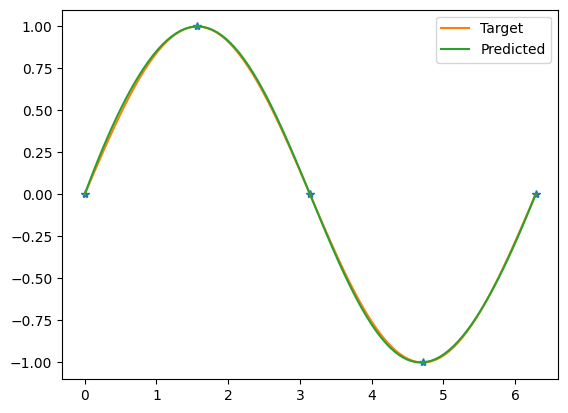

当前训练个数num_epochs: 33000
epoch 200: Loss = 0.0000
epoch 400: Loss = 0.0000
epoch 600: Loss = 0.0000
epoch 800: Loss = 0.0000
epoch 1000: Loss = 0.0000
epoch 1200: Loss = 0.0000
epoch 1400: Loss = 0.0000
epoch 1600: Loss = 0.0000
epoch 1800: Loss = 0.0000
epoch 2000: Loss = 0.0000
epoch 2200: Loss = 0.0000
epoch 2400: Loss = 0.0000
epoch 2600: Loss = 0.0000
epoch 2800: Loss = 0.0000
epoch 3000: Loss = 0.0000
epoch 3200: Loss = 0.0000
epoch 3400: Loss = 0.0000
epoch 3600: Loss = 0.0000
epoch 3800: Loss = 0.0000
epoch 4000: Loss = 0.0000
epoch 4200: Loss = 0.0000
epoch 4400: Loss = 0.0000
epoch 4600: Loss = 0.0000
epoch 4800: Loss = 0.0000
epoch 5000: Loss = 0.0000
epoch 5200: Loss = 0.0000
epoch 5400: Loss = 0.0000
epoch 5600: Loss = 0.0000
epoch 5800: Loss = 0.0000
epoch 6000: Loss = 0.0000
epoch 6200: Loss = 0.0000
epoch 6400: Loss = 0.0000
epoch 6600: Loss = 0.0000
epoch 6800: Loss = 0.0000
epoch 7000: Loss = 0.0000
epoch 7200: Loss = 0.0000
epoch 7400: Loss = 0.0000
epoch 7600: Loss =

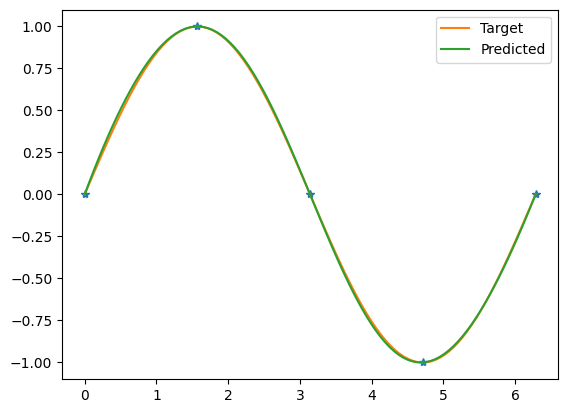

当前训练个数num_epochs: 35000
epoch 200: Loss = 0.0000
epoch 400: Loss = 0.0000
epoch 600: Loss = 0.0000
epoch 800: Loss = 0.0000
epoch 1000: Loss = 0.0000
epoch 1200: Loss = 0.0000
epoch 1400: Loss = 0.0000
epoch 1600: Loss = 0.0000
epoch 1800: Loss = 0.0000
epoch 2000: Loss = 0.0000
epoch 2200: Loss = 0.0000
epoch 2400: Loss = 0.0000
epoch 2600: Loss = 0.0000
epoch 2800: Loss = 0.0000
epoch 3000: Loss = 0.0000
epoch 3200: Loss = 0.0000
epoch 3400: Loss = 0.0000
epoch 3600: Loss = 0.0000
epoch 3800: Loss = 0.0000
epoch 4000: Loss = 0.0000
epoch 4200: Loss = 0.0000
epoch 4400: Loss = 0.0000
epoch 4600: Loss = 0.0000
epoch 4800: Loss = 0.0000
epoch 5000: Loss = 0.0000
epoch 5200: Loss = 0.0000
epoch 5400: Loss = 0.0000
epoch 5600: Loss = 0.0000
epoch 5800: Loss = 0.0000
epoch 6000: Loss = 0.0000
epoch 6200: Loss = 0.0000
epoch 6400: Loss = 0.0000
epoch 6600: Loss = 0.0000
epoch 6800: Loss = 0.0000
epoch 7000: Loss = 0.0000
epoch 7200: Loss = 0.0000
epoch 7400: Loss = 0.0000
epoch 7600: Loss =

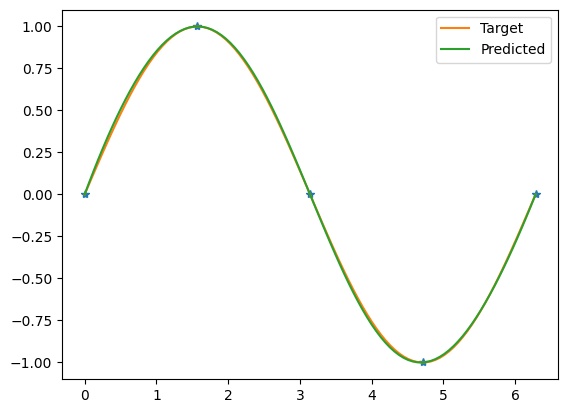

当前训练个数num_epochs: 37000
epoch 200: Loss = 0.0000
epoch 400: Loss = 0.0000
epoch 600: Loss = 0.0000
epoch 800: Loss = 0.0000
epoch 1000: Loss = 0.0000
epoch 1200: Loss = 0.0000
epoch 1400: Loss = 0.0000
epoch 1600: Loss = 0.0000
epoch 1800: Loss = 0.0000
epoch 2000: Loss = 0.0000
epoch 2200: Loss = 0.0000
epoch 2400: Loss = 0.0000
epoch 2600: Loss = 0.0000
epoch 2800: Loss = 0.0000
epoch 3000: Loss = 0.0000
epoch 3200: Loss = 0.0000
epoch 3400: Loss = 0.0000
epoch 3600: Loss = 0.0000
epoch 3800: Loss = 0.0000
epoch 4000: Loss = 0.0000
epoch 4200: Loss = 0.0000
epoch 4400: Loss = 0.0000
epoch 4600: Loss = 0.0000
epoch 4800: Loss = 0.0000
epoch 5000: Loss = 0.0000
epoch 5200: Loss = 0.0000
epoch 5400: Loss = 0.0000
epoch 5600: Loss = 0.0000
epoch 5800: Loss = 0.0000
epoch 6000: Loss = 0.0000
epoch 6200: Loss = 0.0000
epoch 6400: Loss = 0.0000
epoch 6600: Loss = 0.0000
epoch 6800: Loss = 0.0000
epoch 7000: Loss = 0.0000
epoch 7200: Loss = 0.0000
epoch 7400: Loss = 0.0000
epoch 7600: Loss =

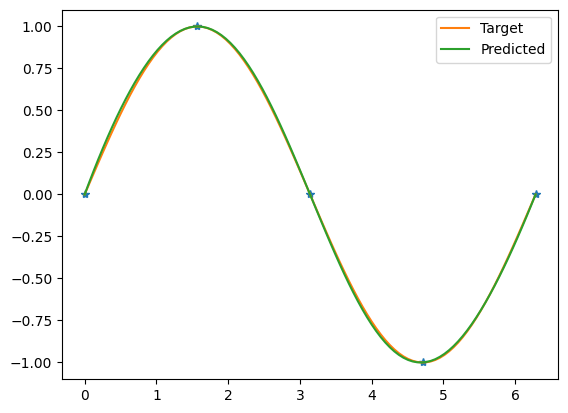

当前训练个数num_epochs: 39000
epoch 200: Loss = 0.0000
epoch 400: Loss = 0.0000
epoch 600: Loss = 0.0000
epoch 800: Loss = 0.0000
epoch 1000: Loss = 0.0000
epoch 1200: Loss = 0.0000
epoch 1400: Loss = 0.0000
epoch 1600: Loss = 0.0000
epoch 1800: Loss = 0.0000


KeyboardInterrupt: 

In [105]:
for i in range(1000,100000,2000):
    #输出当前数据个数，标记
    print("当前训练个数num_epochs:",i)
    train_model(model,num_epochs = i,data_num = 5)

已经可以看到数据少的时候函数如何拟合，数据量的规模对网络的性能影响很大。如果是少量数据我们需要更多的epoch去训练，才能达数据量大规模情况下一样的效果

# 关于第一节课实验课的实验思考：
我们在实验中获得了很好的效果，但是我们在实验中也遇到了很多问题，我们在实验中遇到的问题有：
- 1、首先是拟合函数越复杂，我们就需要更复杂的神经网络来实现
- 2、其次是我们在实验中发现，我们的神经网络拟合效果和我们的神经网络的参数初始化有很大的关系，我们的神经网络参数初始化的不好，我们的神经网络就无法拟合我们的函数
- 3、我在自己试验过程中发现，数据是一个很重要的因素，数据的质量和数量对实验结果影响很大。在我选择的拟合函数中，采样数据点的个数影响着拟合效果。我们在真实场景中的拟合往往不会有很多数据，少样本学习是一件很常见的事。这次实验中我尝试不断缩小数据个数去实现拟合，发在sin函数和cos函数拟合过程中至少需要5个数据，低于5很难取得很好的效果。而在少量数据时候，我们要想取得和之前大规模数据集上相同的效果，至少需要更多的epoch
- 4、网络的超参数对网络性能影响很大